In [1]:
import torch
import numpy as np
import pandas as pd
import transformers
from sklearn.model_selection import train_test_split
from transformers import AutoModel, BertTokenizerFast
from tqdm import tqdm
torch.cuda.is_available()

True

In [2]:
CVAP_all_SD_df = pd.read_csv('./ChineseEmoBank/CVAP_SD/CVAP_all_SD.csv', encoding= 'utf-8',sep="\t")
df0 = CVAP_all_SD_df.drop(['No.','Valence_SD', 'Arousal_SD'], axis= 1)
df0['class'] = 'Phrase'
#df0.columns = ['Phrase', 'Valence_Mean', 'Arousal_Mean', 'class']

CVAS_all_SD_df = pd.read_csv('./ChineseEmoBank/CVAS_SD/CVAS_all.csv', encoding= 'utf-8',sep="\t")
df1 = CVAS_all_SD_df.drop(['Valence_SD', 'Arousal_SD'], axis= 1)
df1['class'] = 'Text'
df1.columns = ['Phrase', 'Valence_Mean', 'Arousal_Mean', 'class']


CVAW_all_SD_df = pd.read_csv('./ChineseEmoBank/CVAW_SD/CVAW_all_SD.csv', encoding= 'utf-8',sep="\t")
df2 = CVAW_all_SD_df.drop(['No.','Valence_SD', 'Arousal_SD'], axis= 1)
df2['class'] = 'Word'
df2.columns = ['Phrase', 'Valence_Mean', 'Arousal_Mean', 'class']


#df = CVAP_all_SD_df.drop(['No.','Valence_SD', 'Arousal_SD'], axis= 1)
print(df0.loc[1])
print(df1.loc[1])
print(df2.loc[1])

Phrase            更加小心
Valence_Mean     5.111
Arousal_Mean     7.188
class           Phrase
Name: 1, dtype: object
Phrase          每一樣都美好得不可思議
Valence_Mean           7.75
Arousal_Mean            7.4
class                  Text
Name: 1, dtype: object
Phrase            不平
Valence_Mean     3.6
Arousal_Mean     5.8
class           Word
Name: 1, dtype: object


In [3]:
#df = pd.concat([df0,df1,df2], axis= 0).reset_index(drop= True)
#df = df0
#df.loc[0]
combined_df = pd.concat([df0, df1, df2], ignore_index=True)

# 将'class'列转换为哑变量
dummy_class = pd.get_dummies(combined_df['class'], prefix='class')

# 将哑变量与原始数据帧合并
combined_df = pd.concat([combined_df, dummy_class], axis=1)

# 删除原始的'class'列
combined_df = combined_df.drop('class', axis=1)
df = combined_df
df


,Phrase,Valence_Mean,Arousal_Mean,class_Phrase,class_Text,class_Word
0,怪八卦,3.450,4.383,1,0,0
1,更加小心,5.111,7.188,1,0,0
2,格外小心,3.950,6.500,1,0,0
3,特別小心,5.000,7.000,1,0,0
4,極為小心,3.989,6.925,1,0,0
...,...,...,...,...,...,...
10340,黏膩,2.700,5.800,0,0,1
10341,艷麗,5.800,4.500,0,0,1
10342,豔麗,5.800,4.500,0,0,1
10343,苗條,6.700,3.800,0,0,1


In [4]:

# 提取特徵和標籤
#X = df[['Valence_Mean', 'Arousal_Mean']]
#y = df['Phrase'] # 如果您的數據集中有標籤列，請替換 'label_column_name' 為您的標籤列名稱
x = df['Phrase']
y = df[['Valence_Mean','Arousal_Mean','class_Phrase','class_Text','class_Word']] # 如果您的數據集中有標籤列，請替換 'label_column_name' 為您的標籤列名稱

# 將數據集分成訓練集和測試集，以 80:20 的比例分割
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42, train_size= 0.8)
print(x_train)


3209    還輪得到他們一天到晚在網上放屁
7666                 困在
9968                 貶損
3643        展現自己健美肉體以敬神
6606                 許可
             ...       
5734                 深思
5191                 妄想
5390                 放縱
860                異常嚴格
7270                 故意
Name: Phrase, Length: 7758, dtype: object


In [5]:
#bert = AutoModel.from_pretrained('bert-base-chinese', return_dict=False)
#tokenizer = BertTokenizerFast.from_pretrained('bert-base-chinese')

from transformers import (
  BertTokenizerFast,
  AutoModel,
)

tokenizer = BertTokenizerFast.from_pretrained('bert-base-chinese')
bert = AutoModel.from_pretrained('ckiplab/bert-base-chinese', return_dict=False)

Some weights of the model checkpoint at ckiplab/bert-base-chinese were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at ckiplab/bert-base-chinese and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dens

In [6]:
train_idx = x_train.dropna().index
test_idx = x_test.dropna().index

train_tokens = tokenizer.batch_encode_plus(x_train[train_idx].to_list(),
                                           max_length = 50,
                                           #pad_to_max_length = True,
                                           padding=True,
                                           truncation = True)
test_tokens = tokenizer.batch_encode_plus(x_test[test_idx].to_list(),
                                           max_length = 50,
                                          # pad_to_max_length = True,
                                           padding=True,
                                           truncation = True)
#print(y_train['Valence_Mean'])
# y_train = y_train.reset_index(drop = True)
#y_train.loc[0]

In [7]:
train_seq = torch.tensor(train_tokens['input_ids'])
train_mask = torch.tensor(train_tokens['attention_mask'])
# print([i for i in y_train['Valence_Mean']])
# train_y = torch.tensor([i for i in y_train['Valence_Mean']])
train_y = torch.tensor([(i, j) for i, j in zip(y_train['Valence_Mean'], y_train['Arousal_Mean'])])
test_seq = torch.tensor(test_tokens['input_ids'])
test_mask = torch.tensor(test_tokens['attention_mask'])
#test_y = torch.tensor([i for i in y_test['Valence_Mean']])
test_y = torch.tensor([(i, j) for i, j in zip(y_test['Valence_Mean'], y_test['Arousal_Mean'])])

In [8]:
from torch.utils.data import TensorDataset, RandomSampler, DataLoader

In [9]:
train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
trainloader = DataLoader(train_data, 
                         sampler = train_sampler,
                         batch_size = 32)

test_data = TensorDataset(test_seq, test_mask, test_y)
test_sampler = RandomSampler(test_data)
testloader = DataLoader(test_data, 
                         sampler = test_sampler,
                         batch_size = 32)

In [10]:
for param in bert.parameters():
    param.requires_grad = False

In [11]:
from torch import nn
from transformers import AdamW
import torch.nn.functional as F
from sklearn.utils.class_weight import compute_class_weight

In [12]:
# class BertRegressor(nn.Module):
#     def __init__(self, bert):
#         super().__init__()
#         self.bert = bert
#         self.fc1 = nn.Linear(768, 1)  # output one continuous value
    
#     def forward(self, sent_id, mask):
#         _, cls_hs = self.bert(sent_id, attention_mask=mask)
#         return self.fc1(cls_hs).squeeze()  # remove the last dimension of size 1
    
class BertRegressor(nn.Module):
    def __init__(self, bert):
        super().__init__()
        self.bert = bert
        self.fc1 = nn.Linear(768, 128)  # add a linear layer with output size 128
        self.relu = nn.ReLU()  # add ReLU activation function
        self.fc2 = nn.Linear(128, 128)  # output one continuous value
        self.fc3 = nn.Linear(128, 2)  # output one continuous value

    def forward(self, sent_id, mask):
        _, cls_hs = self.bert(sent_id, attention_mask=mask)
        x = self.fc1(cls_hs)
        x = self.relu(x)  # apply ReLU activation
        x = self.fc2(x)
        x = self.relu(x)  # apply ReLU activation
        # return self.fc3(x).squeeze()  # remove the last dimension of size 1
        return self.fc3(x)


In [13]:
model = BertRegressor(bert)
model = model.cuda()

In [14]:
optimizer = AdamW(model.parameters(), lr=1e-5)

c:\Program Files\Python\38\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [15]:
# def loss_fn(outputs, targets):
#     return F.mse_loss(outputs, targets)

In [16]:
#criterion = nn.MSELoss()
#criterion = nn.MSELoss(reduction='sum')
criterion = torch.nn.SmoothL1Loss(reduction='mean')

In [17]:
from tqdm import tqdm
# def early_stopping(train_loss, validation_loss, min_delta, tolerance):

#     counter = 0
#     if (validation_loss - train_loss) > min_delta:
#         counter +=1
#         if counter >= tolerance:
#           return True

In [18]:
epochs = 1000
losses = []
for e in range(epochs):   
    train_loss = 0.0
    for batch in tqdm(trainloader):
        batch = [i.cuda() for i in batch]
        sent_id, masks, labels = batch

        optimizer.zero_grad()
        preds = model(sent_id, masks)
        loss = criterion(preds, labels)
        train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
    losses.append(train_loss / len(trainloader))
    # if early_stopping(epoch_train_loss, epoch_validate_loss, min_delta=10, tolerance = 20):
    #   print("We are at epoch:", i)
    #   break
    print(f'Epoch:{e+1}\t\tTraining Loss: {train_loss / len(trainloader)}')

100%|██████████| 243/243 [00:19<00:00, 12.75it/s]


Epoch:1		Training Loss: 4.202845693125155


100%|██████████| 243/243 [00:18<00:00, 13.28it/s]


Epoch:2		Training Loss: 3.562683103506457


100%|██████████| 243/243 [00:16<00:00, 14.37it/s]


Epoch:3		Training Loss: 2.635924649336701


100%|██████████| 243/243 [00:16<00:00, 14.51it/s]


Epoch:4		Training Loss: 1.5146928434509308


100%|██████████| 243/243 [00:17<00:00, 13.69it/s]


Epoch:5		Training Loss: 0.8809336107454182


100%|██████████| 243/243 [00:17<00:00, 13.64it/s]


Epoch:6		Training Loss: 0.8329477069799792


100%|██████████| 243/243 [00:17<00:00, 13.61it/s]


Epoch:7		Training Loss: 0.8200233360376868


100%|██████████| 243/243 [00:17<00:00, 13.92it/s]


Epoch:8		Training Loss: 0.8107271128230624


100%|██████████| 243/243 [00:17<00:00, 13.92it/s]


Epoch:9		Training Loss: 0.8008560479423146


100%|██████████| 243/243 [00:17<00:00, 13.76it/s]


Epoch:10		Training Loss: 0.793378931995282


100%|██████████| 243/243 [00:17<00:00, 13.95it/s]


Epoch:11		Training Loss: 0.7844893125349602


100%|██████████| 243/243 [00:17<00:00, 13.96it/s]


Epoch:12		Training Loss: 0.7763976574925239


100%|██████████| 243/243 [00:17<00:00, 13.95it/s]


Epoch:13		Training Loss: 0.7681206795904372


100%|██████████| 243/243 [00:17<00:00, 13.94it/s]


Epoch:14		Training Loss: 0.7586659460401339


100%|██████████| 243/243 [00:17<00:00, 13.94it/s]


Epoch:15		Training Loss: 0.7497045704366739


100%|██████████| 243/243 [00:17<00:00, 13.94it/s]


Epoch:16		Training Loss: 0.7392001924691377


100%|██████████| 243/243 [00:17<00:00, 13.94it/s]


Epoch:17		Training Loss: 0.728332564173412


100%|██████████| 243/243 [00:17<00:00, 13.93it/s]


Epoch:18		Training Loss: 0.7160843620575014


100%|██████████| 243/243 [00:17<00:00, 13.94it/s]


Epoch:19		Training Loss: 0.7050231756496822


100%|██████████| 243/243 [00:17<00:00, 13.93it/s]


Epoch:20		Training Loss: 0.6939374882988478


100%|██████████| 243/243 [00:17<00:00, 13.94it/s]


Epoch:21		Training Loss: 0.6835208530288664


100%|██████████| 243/243 [00:17<00:00, 13.93it/s]


Epoch:22		Training Loss: 0.6716657979988757


100%|██████████| 243/243 [00:17<00:00, 13.94it/s]


Epoch:23		Training Loss: 0.6624000867207845


100%|██████████| 243/243 [00:17<00:00, 13.94it/s]


Epoch:24		Training Loss: 0.6527863751958918


100%|██████████| 243/243 [00:17<00:00, 13.88it/s]


Epoch:25		Training Loss: 0.6449211971995271


100%|██████████| 243/243 [00:17<00:00, 13.88it/s]


Epoch:26		Training Loss: 0.6370154832616265


100%|██████████| 243/243 [00:17<00:00, 13.89it/s]


Epoch:27		Training Loss: 0.6300723524495898


100%|██████████| 243/243 [00:17<00:00, 13.89it/s]


Epoch:28		Training Loss: 0.6244620739677806


100%|██████████| 243/243 [00:17<00:00, 13.90it/s]


Epoch:29		Training Loss: 0.6184275230017219


100%|██████████| 243/243 [00:17<00:00, 13.94it/s]


Epoch:30		Training Loss: 0.6143728916537124


100%|██████████| 243/243 [00:17<00:00, 13.93it/s]


Epoch:31		Training Loss: 0.6088320350450743


100%|██████████| 243/243 [00:17<00:00, 13.92it/s]


Epoch:32		Training Loss: 0.6051386419392417


100%|██████████| 243/243 [00:17<00:00, 13.94it/s]


Epoch:33		Training Loss: 0.6010104252232445


100%|██████████| 243/243 [00:17<00:00, 13.93it/s]


Epoch:34		Training Loss: 0.5980538747928761


100%|██████████| 243/243 [00:17<00:00, 13.93it/s]


Epoch:35		Training Loss: 0.5942757449768208


100%|██████████| 243/243 [00:17<00:00, 13.93it/s]


Epoch:36		Training Loss: 0.591769262228483


100%|██████████| 243/243 [00:17<00:00, 13.93it/s]


Epoch:37		Training Loss: 0.5882984129980268


100%|██████████| 243/243 [00:17<00:00, 13.93it/s]


Epoch:38		Training Loss: 0.5869092260613854


100%|██████████| 243/243 [00:17<00:00, 13.93it/s]


Epoch:39		Training Loss: 0.584248216063888


100%|██████████| 243/243 [00:17<00:00, 13.93it/s]


Epoch:40		Training Loss: 0.5816698604159884


100%|██████████| 243/243 [00:17<00:00, 13.93it/s]


Epoch:41		Training Loss: 0.5795828551667217


100%|██████████| 243/243 [00:17<00:00, 13.93it/s]


Epoch:42		Training Loss: 0.5775367146656837


100%|██████████| 243/243 [00:17<00:00, 13.94it/s]


Epoch:43		Training Loss: 0.5761303879596569


100%|██████████| 243/243 [00:17<00:00, 13.93it/s]


Epoch:44		Training Loss: 0.5737163403642521


100%|██████████| 243/243 [00:17<00:00, 13.93it/s]


Epoch:45		Training Loss: 0.5724406498695107


100%|██████████| 243/243 [00:17<00:00, 13.94it/s]


Epoch:46		Training Loss: 0.5700777448989727


100%|██████████| 243/243 [00:17<00:00, 13.94it/s]


Epoch:47		Training Loss: 0.5677692031664122


100%|██████████| 243/243 [00:17<00:00, 13.93it/s]


Epoch:48		Training Loss: 0.5667901718567429


100%|██████████| 243/243 [00:17<00:00, 13.93it/s]


Epoch:49		Training Loss: 0.565563498823731


100%|██████████| 243/243 [00:17<00:00, 13.93it/s]


Epoch:50		Training Loss: 0.5633503095603284


100%|██████████| 243/243 [00:17<00:00, 13.93it/s]


Epoch:51		Training Loss: 0.5623187687661912


100%|██████████| 243/243 [00:17<00:00, 13.93it/s]


Epoch:52		Training Loss: 0.5605205146618831


100%|██████████| 243/243 [00:17<00:00, 13.93it/s]


Epoch:53		Training Loss: 0.5588266632439177


100%|██████████| 243/243 [00:17<00:00, 13.94it/s]


Epoch:54		Training Loss: 0.558083565637408


100%|██████████| 243/243 [00:17<00:00, 13.93it/s]


Epoch:55		Training Loss: 0.5567997121271283


100%|██████████| 243/243 [00:17<00:00, 13.93it/s]


Epoch:56		Training Loss: 0.5549210332058094


100%|██████████| 243/243 [00:17<00:00, 13.94it/s]


Epoch:57		Training Loss: 0.5541232804702633


100%|██████████| 243/243 [00:17<00:00, 13.94it/s]


Epoch:58		Training Loss: 0.5523705045872755


100%|██████████| 243/243 [00:17<00:00, 13.93it/s]


Epoch:59		Training Loss: 0.5512032004786126


100%|██████████| 243/243 [00:17<00:00, 13.93it/s]


Epoch:60		Training Loss: 0.5502153102753093


100%|██████████| 243/243 [00:17<00:00, 13.94it/s]


Epoch:61		Training Loss: 0.5481356346803438


100%|██████████| 243/243 [00:17<00:00, 13.89it/s]


Epoch:62		Training Loss: 0.5472112691696779


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:63		Training Loss: 0.5459972073021249


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:64		Training Loss: 0.5448354531708077


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:65		Training Loss: 0.5442364290663244


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:66		Training Loss: 0.5420369048422746


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:67		Training Loss: 0.5410160724027657


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:68		Training Loss: 0.5399422029899471


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:69		Training Loss: 0.5383064738271658


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:70		Training Loss: 0.5368934897974195


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:71		Training Loss: 0.5362242757047645


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:72		Training Loss: 0.5355338893309542


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:73		Training Loss: 0.5338635178505148


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:74		Training Loss: 0.5328932457254747


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:75		Training Loss: 0.5315897702680203


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:76		Training Loss: 0.530987504333135


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:77		Training Loss: 0.5298695720027014


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:78		Training Loss: 0.5283929784111525


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:79		Training Loss: 0.5280208191508619


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:80		Training Loss: 0.5268685834888568


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:81		Training Loss: 0.525550861662798


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:82		Training Loss: 0.5250236184753999


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:83		Training Loss: 0.5236531980489016


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:84		Training Loss: 0.522224425778958


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:85		Training Loss: 0.5216445667753494


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:86		Training Loss: 0.5205829645135275


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:87		Training Loss: 0.5205446974730786


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:88		Training Loss: 0.5190566394309448


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:89		Training Loss: 0.517759715333397


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:90		Training Loss: 0.5171235115439804


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:91		Training Loss: 0.5161060288609791


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:92		Training Loss: 0.514733959740572


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:93		Training Loss: 0.5151237059277272


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:94		Training Loss: 0.5135980416472556


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:95		Training Loss: 0.5131832968305658


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:96		Training Loss: 0.5126362879580431


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:97		Training Loss: 0.5111247020248523


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:98		Training Loss: 0.5101471955393567


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:99		Training Loss: 0.5101357989105177


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:100		Training Loss: 0.508548086194835


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:101		Training Loss: 0.5077929426858454


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:102		Training Loss: 0.5071721469423899


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:103		Training Loss: 0.5062752683712132


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:104		Training Loss: 0.5057358389773977


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:105		Training Loss: 0.504760532222167


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:106		Training Loss: 0.5040403687904892


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:107		Training Loss: 0.5038892863463963


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:108		Training Loss: 0.5029187289530358


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:109		Training Loss: 0.5019902869016545


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:110		Training Loss: 0.5016837559119174


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:111		Training Loss: 0.5005073657742253


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:112		Training Loss: 0.49981324196842963


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:113		Training Loss: 0.4991459347338343


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:114		Training Loss: 0.4983983498541907


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:115		Training Loss: 0.49774035934067556


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:116		Training Loss: 0.49716658933172503


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:117		Training Loss: 0.49583690254776563


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:118		Training Loss: 0.4956769533608676


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:119		Training Loss: 0.4942474550425761


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:120		Training Loss: 0.4954433773525458


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:121		Training Loss: 0.4934007574501352


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:122		Training Loss: 0.49268638719747093


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:123		Training Loss: 0.4925923391624733


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:124		Training Loss: 0.49142024264414125


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:125		Training Loss: 0.4910581752105995


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:126		Training Loss: 0.4898180723680881


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:127		Training Loss: 0.4905727029827887


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:128		Training Loss: 0.48942041973518247


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:129		Training Loss: 0.4885243279207881


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:130		Training Loss: 0.4875687512841244


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:131		Training Loss: 0.48739621779065073


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:132		Training Loss: 0.48711209471333666


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:133		Training Loss: 0.486570315964428


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:134		Training Loss: 0.4853156486165867


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:135		Training Loss: 0.48456832079730405


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:136		Training Loss: 0.4845384348321844


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:137		Training Loss: 0.48433437698171955


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:138		Training Loss: 0.4831140063427113


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:139		Training Loss: 0.48224388535130663


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:140		Training Loss: 0.4818864315134998


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:141		Training Loss: 0.48077338296199534


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:142		Training Loss: 0.4803544179892834


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:143		Training Loss: 0.4807622232800158


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:144		Training Loss: 0.4793085194664237


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:145		Training Loss: 0.478569263170776


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:146		Training Loss: 0.4784332518714936


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:147		Training Loss: 0.47779937585194904


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:148		Training Loss: 0.4777925352991363


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:149		Training Loss: 0.4762113517449226


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:150		Training Loss: 0.4759280641137818


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:151		Training Loss: 0.4757823600690551


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:152		Training Loss: 0.47540392318870794


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:153		Training Loss: 0.4746228595084124


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:154		Training Loss: 0.47352632316051685


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:155		Training Loss: 0.47365278557494833


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:156		Training Loss: 0.4728895928634047


100%|██████████| 243/243 [00:18<00:00, 13.04it/s]


Epoch:157		Training Loss: 0.47210444209506974


100%|██████████| 243/243 [00:18<00:00, 13.45it/s]


Epoch:158		Training Loss: 0.4715080593593817


100%|██████████| 243/243 [00:18<00:00, 13.45it/s]


Epoch:159		Training Loss: 0.4712139104374152


100%|██████████| 243/243 [00:18<00:00, 13.44it/s]


Epoch:160		Training Loss: 0.47094656496381565


100%|██████████| 243/243 [00:18<00:00, 13.21it/s]


Epoch:161		Training Loss: 0.47016940520378786


100%|██████████| 243/243 [00:18<00:00, 13.42it/s]


Epoch:162		Training Loss: 0.46952807400452257


100%|██████████| 243/243 [00:18<00:00, 13.43it/s]


Epoch:163		Training Loss: 0.46892597308620015


100%|██████████| 243/243 [00:18<00:00, 13.44it/s]


Epoch:164		Training Loss: 0.4683250761571735


100%|██████████| 243/243 [00:17<00:00, 13.56it/s]


Epoch:165		Training Loss: 0.4671510816110996


100%|██████████| 243/243 [00:17<00:00, 13.68it/s]


Epoch:166		Training Loss: 0.4666888585061203


100%|██████████| 243/243 [00:17<00:00, 13.69it/s]


Epoch:167		Training Loss: 0.467195304026329


100%|██████████| 243/243 [00:17<00:00, 13.58it/s]


Epoch:168		Training Loss: 0.46592347029550574


100%|██████████| 243/243 [00:17<00:00, 13.68it/s]


Epoch:169		Training Loss: 0.4661557561576121


100%|██████████| 243/243 [00:17<00:00, 13.68it/s]


Epoch:170		Training Loss: 0.4652509981222113


100%|██████████| 243/243 [00:17<00:00, 13.56it/s]


Epoch:171		Training Loss: 0.4643550531118495


100%|██████████| 243/243 [00:17<00:00, 13.58it/s]


Epoch:172		Training Loss: 0.4646430014337532


100%|██████████| 243/243 [00:17<00:00, 13.63it/s]


Epoch:173		Training Loss: 0.46336422462031673


100%|██████████| 243/243 [00:18<00:00, 13.43it/s]


Epoch:174		Training Loss: 0.46338445181218685


100%|██████████| 243/243 [00:18<00:00, 13.32it/s]


Epoch:175		Training Loss: 0.4628653375454891


100%|██████████| 243/243 [00:18<00:00, 13.50it/s]


Epoch:176		Training Loss: 0.46308018665745426


100%|██████████| 243/243 [00:18<00:00, 13.47it/s]


Epoch:177		Training Loss: 0.4620891378985511


100%|██████████| 243/243 [00:18<00:00, 13.41it/s]


Epoch:178		Training Loss: 0.4609726006356777


100%|██████████| 243/243 [00:17<00:00, 13.54it/s]


Epoch:179		Training Loss: 0.46083045950151763


100%|██████████| 243/243 [00:18<00:00, 13.37it/s]


Epoch:180		Training Loss: 0.4602737630345694


100%|██████████| 243/243 [00:18<00:00, 13.09it/s]


Epoch:181		Training Loss: 0.4596930576695336


100%|██████████| 243/243 [00:18<00:00, 13.02it/s]


Epoch:182		Training Loss: 0.4586270252863566


100%|██████████| 243/243 [00:18<00:00, 12.89it/s]


Epoch:183		Training Loss: 0.4593069864889231


100%|██████████| 243/243 [00:19<00:00, 12.70it/s]


Epoch:184		Training Loss: 0.45848241313494775


100%|██████████| 243/243 [00:18<00:00, 12.89it/s]


Epoch:185		Training Loss: 0.45816622680597346


100%|██████████| 243/243 [00:18<00:00, 12.95it/s]


Epoch:186		Training Loss: 0.45739188851643003


100%|██████████| 243/243 [00:17<00:00, 13.56it/s]


Epoch:187		Training Loss: 0.45752429532906647


100%|██████████| 243/243 [00:17<00:00, 13.50it/s]


Epoch:188		Training Loss: 0.45614111779158006


100%|██████████| 243/243 [00:17<00:00, 13.66it/s]


Epoch:189		Training Loss: 0.4567378507965386


100%|██████████| 243/243 [00:17<00:00, 13.70it/s]


Epoch:190		Training Loss: 0.455354077825821


100%|██████████| 243/243 [00:17<00:00, 13.77it/s]


Epoch:191		Training Loss: 0.4548783352590883


100%|██████████| 243/243 [00:17<00:00, 13.64it/s]


Epoch:192		Training Loss: 0.45435589944384225


100%|██████████| 243/243 [00:17<00:00, 13.58it/s]


Epoch:193		Training Loss: 0.454113282784513


100%|██████████| 243/243 [00:17<00:00, 13.73it/s]


Epoch:194		Training Loss: 0.45378390659765944


100%|██████████| 243/243 [00:17<00:00, 13.89it/s]


Epoch:195		Training Loss: 0.4532393286993474


100%|██████████| 243/243 [00:17<00:00, 13.71it/s]


Epoch:196		Training Loss: 0.45258012708322504


100%|██████████| 243/243 [00:17<00:00, 13.75it/s]


Epoch:197		Training Loss: 0.452588291202553


100%|██████████| 243/243 [00:17<00:00, 13.56it/s]


Epoch:198		Training Loss: 0.45154935697959775


100%|██████████| 243/243 [00:17<00:00, 13.62it/s]


Epoch:199		Training Loss: 0.4509739000120281


100%|██████████| 243/243 [00:17<00:00, 13.66it/s]


Epoch:200		Training Loss: 0.450947222027759


100%|██████████| 243/243 [00:17<00:00, 13.76it/s]


Epoch:201		Training Loss: 0.44998932007408926


100%|██████████| 243/243 [00:17<00:00, 13.66it/s]


Epoch:202		Training Loss: 0.4499649254014953


100%|██████████| 243/243 [00:17<00:00, 13.76it/s]


Epoch:203		Training Loss: 0.4493826557824641


100%|██████████| 243/243 [00:17<00:00, 13.72it/s]


Epoch:204		Training Loss: 0.4483397703602481


100%|██████████| 243/243 [00:17<00:00, 13.68it/s]


Epoch:205		Training Loss: 0.4486493394698626


100%|██████████| 243/243 [00:17<00:00, 13.59it/s]


Epoch:206		Training Loss: 0.44841818456296567


100%|██████████| 243/243 [00:18<00:00, 13.32it/s]


Epoch:207		Training Loss: 0.4471964252338488


100%|██████████| 243/243 [00:17<00:00, 13.66it/s]


Epoch:208		Training Loss: 0.446723482245771


100%|██████████| 243/243 [00:18<00:00, 13.39it/s]


Epoch:209		Training Loss: 0.4461620427944042


100%|██████████| 243/243 [00:17<00:00, 13.57it/s]


Epoch:210		Training Loss: 0.4453622138303984


100%|██████████| 243/243 [00:17<00:00, 13.71it/s]


Epoch:211		Training Loss: 0.4453236081717927


100%|██████████| 243/243 [00:17<00:00, 13.80it/s]


Epoch:212		Training Loss: 0.4445988456162896


100%|██████████| 243/243 [00:17<00:00, 13.54it/s]


Epoch:213		Training Loss: 0.4448491835299833


100%|██████████| 243/243 [00:18<00:00, 13.43it/s]


Epoch:214		Training Loss: 0.4440544318760373


100%|██████████| 243/243 [00:18<00:00, 13.31it/s]


Epoch:215		Training Loss: 0.44387168532291066


100%|██████████| 243/243 [00:18<00:00, 13.47it/s]


Epoch:216		Training Loss: 0.4434412064130414


100%|██████████| 243/243 [00:18<00:00, 13.31it/s]


Epoch:217		Training Loss: 0.4426692956023746


100%|██████████| 243/243 [00:18<00:00, 13.16it/s]


Epoch:218		Training Loss: 0.44198858541716274


100%|██████████| 243/243 [00:18<00:00, 13.33it/s]


Epoch:219		Training Loss: 0.4418816193631647


100%|██████████| 243/243 [00:18<00:00, 13.20it/s]


Epoch:220		Training Loss: 0.44136507514818213


100%|██████████| 243/243 [00:18<00:00, 13.24it/s]


Epoch:221		Training Loss: 0.4410956241956954


100%|██████████| 243/243 [00:18<00:00, 13.19it/s]


Epoch:222		Training Loss: 0.4405824600914378


100%|██████████| 243/243 [00:18<00:00, 13.34it/s]


Epoch:223		Training Loss: 0.43987788094414604


100%|██████████| 243/243 [00:18<00:00, 13.13it/s]


Epoch:224		Training Loss: 0.43976216048860745


100%|██████████| 243/243 [00:18<00:00, 13.34it/s]


Epoch:225		Training Loss: 0.43953725413530453


100%|██████████| 243/243 [00:18<00:00, 13.49it/s]


Epoch:226		Training Loss: 0.4387144750528375


100%|██████████| 243/243 [00:17<00:00, 13.56it/s]


Epoch:227		Training Loss: 0.43818160768889597


100%|██████████| 243/243 [00:18<00:00, 13.39it/s]


Epoch:228		Training Loss: 0.4379509383268317


100%|██████████| 243/243 [00:18<00:00, 13.48it/s]


Epoch:229		Training Loss: 0.4378494480509817


100%|██████████| 243/243 [00:18<00:00, 13.30it/s]


Epoch:230		Training Loss: 0.43673499045058045


100%|██████████| 243/243 [00:18<00:00, 13.24it/s]


Epoch:231		Training Loss: 0.43648443067515336


100%|██████████| 243/243 [00:18<00:00, 13.30it/s]


Epoch:232		Training Loss: 0.4364324218206445


100%|██████████| 243/243 [00:18<00:00, 13.12it/s]


Epoch:233		Training Loss: 0.4361459309304202


100%|██████████| 243/243 [00:18<00:00, 13.26it/s]


Epoch:234		Training Loss: 0.4352492339326521


100%|██████████| 243/243 [00:18<00:00, 13.46it/s]


Epoch:235		Training Loss: 0.43435322723270936


100%|██████████| 243/243 [00:18<00:00, 13.31it/s]


Epoch:236		Training Loss: 0.4352733827667472


100%|██████████| 243/243 [00:18<00:00, 13.47it/s]


Epoch:237		Training Loss: 0.4339034814280247


100%|██████████| 243/243 [00:18<00:00, 13.41it/s]


Epoch:238		Training Loss: 0.4329654018820068


100%|██████████| 243/243 [00:18<00:00, 13.41it/s]


Epoch:239		Training Loss: 0.4332323093350532


100%|██████████| 243/243 [00:18<00:00, 13.39it/s]


Epoch:240		Training Loss: 0.4328265547629737


100%|██████████| 243/243 [00:18<00:00, 13.41it/s]


Epoch:241		Training Loss: 0.4319169525011086


100%|██████████| 243/243 [00:18<00:00, 13.40it/s]


Epoch:242		Training Loss: 0.4322174681434906


100%|██████████| 243/243 [00:18<00:00, 13.22it/s]


Epoch:243		Training Loss: 0.43099028528227235


100%|██████████| 243/243 [00:18<00:00, 13.44it/s]


Epoch:244		Training Loss: 0.43069584845515435


100%|██████████| 243/243 [00:18<00:00, 13.34it/s]


Epoch:245		Training Loss: 0.4303866346431858


100%|██████████| 243/243 [00:18<00:00, 13.26it/s]


Epoch:246		Training Loss: 0.42968445703571223


100%|██████████| 243/243 [00:18<00:00, 13.45it/s]


Epoch:247		Training Loss: 0.4294922348157859


100%|██████████| 243/243 [00:18<00:00, 13.26it/s]


Epoch:248		Training Loss: 0.42924430659769003


100%|██████████| 243/243 [00:18<00:00, 13.43it/s]


Epoch:249		Training Loss: 0.42925646766223047


100%|██████████| 243/243 [00:17<00:00, 13.55it/s]


Epoch:250		Training Loss: 0.42953660237936325


100%|██████████| 243/243 [00:18<00:00, 13.42it/s]


Epoch:251		Training Loss: 0.4284620164843744


100%|██████████| 243/243 [00:17<00:00, 13.58it/s]


Epoch:252		Training Loss: 0.4272580665570718


100%|██████████| 243/243 [00:17<00:00, 13.63it/s]


Epoch:253		Training Loss: 0.4273301285726053


100%|██████████| 243/243 [00:17<00:00, 13.62it/s]


Epoch:254		Training Loss: 0.4265451908356859


100%|██████████| 243/243 [00:17<00:00, 13.55it/s]


Epoch:255		Training Loss: 0.4264411707964454


100%|██████████| 243/243 [00:17<00:00, 13.51it/s]


Epoch:256		Training Loss: 0.42582355225037155


100%|██████████| 243/243 [00:18<00:00, 13.38it/s]


Epoch:257		Training Loss: 0.42538404783594264


100%|██████████| 243/243 [00:18<00:00, 13.41it/s]


Epoch:258		Training Loss: 0.4251565396049876


100%|██████████| 243/243 [00:18<00:00, 13.40it/s]


Epoch:259		Training Loss: 0.424818799880797


100%|██████████| 243/243 [00:18<00:00, 13.45it/s]


Epoch:260		Training Loss: 0.4245891724962266


100%|██████████| 243/243 [00:18<00:00, 13.46it/s]


Epoch:261		Training Loss: 0.42379405438409423


100%|██████████| 243/243 [00:18<00:00, 13.45it/s]


Epoch:262		Training Loss: 0.4231449777697339


100%|██████████| 243/243 [00:18<00:00, 13.46it/s]


Epoch:263		Training Loss: 0.42300239088849273


100%|██████████| 243/243 [00:18<00:00, 13.45it/s]


Epoch:264		Training Loss: 0.4229002982500649


100%|██████████| 243/243 [00:18<00:00, 13.45it/s]


Epoch:265		Training Loss: 0.4228594756911321


100%|██████████| 243/243 [00:18<00:00, 13.46it/s]


Epoch:266		Training Loss: 0.42136298812956474


100%|██████████| 243/243 [00:18<00:00, 13.46it/s]


Epoch:267		Training Loss: 0.42106959052046633


100%|██████████| 243/243 [00:18<00:00, 13.44it/s]


Epoch:268		Training Loss: 0.4210776612469198


100%|██████████| 243/243 [00:18<00:00, 13.46it/s]


Epoch:269		Training Loss: 0.420716018527133


100%|██████████| 243/243 [00:18<00:00, 13.45it/s]


Epoch:270		Training Loss: 0.4201402413379018


100%|██████████| 243/243 [00:18<00:00, 13.46it/s]


Epoch:271		Training Loss: 0.4200518000640987


100%|██████████| 243/243 [00:18<00:00, 13.45it/s]


Epoch:272		Training Loss: 0.4192693238395722


100%|██████████| 243/243 [00:18<00:00, 13.46it/s]


Epoch:273		Training Loss: 0.4188322635221874


100%|██████████| 243/243 [00:18<00:00, 13.46it/s]


Epoch:274		Training Loss: 0.41866702135698297


100%|██████████| 243/243 [00:18<00:00, 13.46it/s]


Epoch:275		Training Loss: 0.4183764704215674


100%|██████████| 243/243 [00:18<00:00, 13.47it/s]


Epoch:276		Training Loss: 0.41790420105182585


100%|██████████| 243/243 [00:18<00:00, 13.47it/s]


Epoch:277		Training Loss: 0.41711828639968435


100%|██████████| 243/243 [00:18<00:00, 13.47it/s]


Epoch:278		Training Loss: 0.4170147094093723


100%|██████████| 243/243 [00:18<00:00, 13.45it/s]


Epoch:279		Training Loss: 0.4160849188948855


100%|██████████| 243/243 [00:18<00:00, 13.46it/s]


Epoch:280		Training Loss: 0.4163152212468685


100%|██████████| 243/243 [00:18<00:00, 13.46it/s]


Epoch:281		Training Loss: 0.415391997606666


100%|██████████| 243/243 [00:18<00:00, 13.47it/s]


Epoch:282		Training Loss: 0.41536828268457343


100%|██████████| 243/243 [00:18<00:00, 13.48it/s]


Epoch:283		Training Loss: 0.41459534492021727


100%|██████████| 243/243 [00:18<00:00, 13.47it/s]


Epoch:284		Training Loss: 0.4142254462212692


100%|██████████| 243/243 [00:18<00:00, 13.47it/s]


Epoch:285		Training Loss: 0.4144178437597958


100%|██████████| 243/243 [00:18<00:00, 13.46it/s]


Epoch:286		Training Loss: 0.41327539472668257


100%|██████████| 243/243 [00:18<00:00, 13.48it/s]


Epoch:287		Training Loss: 0.4134802197723232


100%|██████████| 243/243 [00:18<00:00, 13.48it/s]


Epoch:288		Training Loss: 0.41356638797516687


100%|██████████| 243/243 [00:18<00:00, 13.48it/s]


Epoch:289		Training Loss: 0.4133052047755983


100%|██████████| 243/243 [00:18<00:00, 13.47it/s]


Epoch:290		Training Loss: 0.41239746325791127


100%|██████████| 243/243 [00:18<00:00, 13.46it/s]


Epoch:291		Training Loss: 0.41133305700227557


100%|██████████| 243/243 [00:17<00:00, 13.56it/s]


Epoch:292		Training Loss: 0.4110916119544104


100%|██████████| 243/243 [00:17<00:00, 13.57it/s]


Epoch:293		Training Loss: 0.4113149515395302


100%|██████████| 243/243 [00:17<00:00, 13.56it/s]


Epoch:294		Training Loss: 0.41045951364952843


100%|██████████| 243/243 [00:17<00:00, 13.56it/s]


Epoch:295		Training Loss: 0.41045563971554794


100%|██████████| 243/243 [00:17<00:00, 13.51it/s]


Epoch:296		Training Loss: 0.40982133818506705


100%|██████████| 243/243 [00:17<00:00, 13.56it/s]


Epoch:297		Training Loss: 0.40950341933548695


100%|██████████| 243/243 [00:17<00:00, 13.59it/s]


Epoch:298		Training Loss: 0.4091380458677747


100%|██████████| 243/243 [00:17<00:00, 13.58it/s]


Epoch:299		Training Loss: 0.4088058349649602


100%|██████████| 243/243 [00:17<00:00, 13.58it/s]


Epoch:300		Training Loss: 0.40850634351679327


100%|██████████| 243/243 [00:17<00:00, 13.58it/s]


Epoch:301		Training Loss: 0.4080144423270912


100%|██████████| 243/243 [00:17<00:00, 13.58it/s]


Epoch:302		Training Loss: 0.4068467189009788


100%|██████████| 243/243 [00:17<00:00, 13.57it/s]


Epoch:303		Training Loss: 0.4070346866247585


100%|██████████| 243/243 [00:17<00:00, 13.57it/s]


Epoch:304		Training Loss: 0.4060481890974712


100%|██████████| 243/243 [00:17<00:00, 13.59it/s]


Epoch:305		Training Loss: 0.40585808805477475


100%|██████████| 243/243 [00:17<00:00, 13.59it/s]


Epoch:306		Training Loss: 0.40543070637885437


100%|██████████| 243/243 [00:17<00:00, 13.54it/s]


Epoch:307		Training Loss: 0.40557128638642315


100%|██████████| 243/243 [00:18<00:00, 13.35it/s]


Epoch:308		Training Loss: 0.4051546604054455


100%|██████████| 243/243 [00:18<00:00, 13.28it/s]


Epoch:309		Training Loss: 0.4048787993168144


100%|██████████| 243/243 [00:18<00:00, 13.09it/s]


Epoch:310		Training Loss: 0.4043911644583376


100%|██████████| 243/243 [00:18<00:00, 13.13it/s]


Epoch:311		Training Loss: 0.40402208599779343


100%|██████████| 243/243 [00:18<00:00, 13.20it/s]


Epoch:312		Training Loss: 0.40318849179970384


100%|██████████| 243/243 [00:18<00:00, 13.35it/s]


Epoch:313		Training Loss: 0.4029963816144339


100%|██████████| 243/243 [00:18<00:00, 13.15it/s]


Epoch:314		Training Loss: 0.40303069733297875


100%|██████████| 243/243 [00:18<00:00, 13.27it/s]


Epoch:315		Training Loss: 0.4026491727235386


100%|██████████| 243/243 [00:18<00:00, 13.28it/s]


Epoch:316		Training Loss: 0.40186582861368547


100%|██████████| 243/243 [00:17<00:00, 13.51it/s]


Epoch:317		Training Loss: 0.4014806097427023


100%|██████████| 243/243 [00:18<00:00, 13.48it/s]


Epoch:318		Training Loss: 0.4013268581511062


100%|██████████| 243/243 [00:18<00:00, 13.46it/s]


Epoch:319		Training Loss: 0.40085733169881405


100%|██████████| 243/243 [00:19<00:00, 12.66it/s]


Epoch:320		Training Loss: 0.4000351119311258


100%|██████████| 243/243 [00:18<00:00, 13.37it/s]


Epoch:321		Training Loss: 0.3998471233579848


100%|██████████| 243/243 [00:17<00:00, 13.67it/s]


Epoch:322		Training Loss: 0.39944012046105576


100%|██████████| 243/243 [00:17<00:00, 13.65it/s]


Epoch:323		Training Loss: 0.3989149906017162


100%|██████████| 243/243 [00:17<00:00, 13.54it/s]


Epoch:324		Training Loss: 0.3988251163635725


100%|██████████| 243/243 [00:18<00:00, 13.41it/s]


Epoch:325		Training Loss: 0.3982528975471057


100%|██████████| 243/243 [00:17<00:00, 13.63it/s]


Epoch:326		Training Loss: 0.397853030650704


100%|██████████| 243/243 [00:17<00:00, 13.62it/s]


Epoch:327		Training Loss: 0.39769470286958014


100%|██████████| 243/243 [00:17<00:00, 13.64it/s]


Epoch:328		Training Loss: 0.3978216501543061


100%|██████████| 243/243 [00:17<00:00, 13.63it/s]


Epoch:329		Training Loss: 0.3975973728384991


100%|██████████| 243/243 [00:17<00:00, 13.64it/s]


Epoch:330		Training Loss: 0.3963816990087062


100%|██████████| 243/243 [00:17<00:00, 13.64it/s]


Epoch:331		Training Loss: 0.396763275680228


100%|██████████| 243/243 [00:17<00:00, 13.65it/s]


Epoch:332		Training Loss: 0.3957542915035177


100%|██████████| 243/243 [00:17<00:00, 13.65it/s]


Epoch:333		Training Loss: 0.3954506057157438


100%|██████████| 243/243 [00:17<00:00, 13.65it/s]


Epoch:334		Training Loss: 0.39530226766081994


100%|██████████| 243/243 [00:17<00:00, 13.65it/s]


Epoch:335		Training Loss: 0.39527088550873746


100%|██████████| 243/243 [00:17<00:00, 13.65it/s]


Epoch:336		Training Loss: 0.3942572255561381


100%|██████████| 243/243 [00:17<00:00, 13.65it/s]


Epoch:337		Training Loss: 0.3945234192864885


100%|██████████| 243/243 [00:17<00:00, 13.67it/s]


Epoch:338		Training Loss: 0.3937677484726219


100%|██████████| 243/243 [00:17<00:00, 13.64it/s]


Epoch:339		Training Loss: 0.39332517006514983


100%|██████████| 243/243 [00:17<00:00, 13.65it/s]


Epoch:340		Training Loss: 0.393434676491184


100%|██████████| 243/243 [00:17<00:00, 13.67it/s]


Epoch:341		Training Loss: 0.39313413662674984


100%|██████████| 243/243 [00:17<00:00, 13.63it/s]


Epoch:342		Training Loss: 0.3927262855287442


100%|██████████| 243/243 [00:17<00:00, 13.65it/s]


Epoch:343		Training Loss: 0.3919780907439597


100%|██████████| 243/243 [00:17<00:00, 13.66it/s]


Epoch:344		Training Loss: 0.3910401252562126


100%|██████████| 243/243 [00:17<00:00, 13.66it/s]


Epoch:345		Training Loss: 0.3911322838484996


100%|██████████| 243/243 [00:17<00:00, 13.66it/s]


Epoch:346		Training Loss: 0.3906683781387384


100%|██████████| 243/243 [00:17<00:00, 13.66it/s]


Epoch:347		Training Loss: 0.390002386621487


100%|██████████| 243/243 [00:17<00:00, 13.66it/s]


Epoch:348		Training Loss: 0.3901852565537755


100%|██████████| 243/243 [00:17<00:00, 13.65it/s]


Epoch:349		Training Loss: 0.38958364160953723


100%|██████████| 243/243 [00:17<00:00, 13.67it/s]


Epoch:350		Training Loss: 0.3898881233523412


100%|██████████| 243/243 [00:17<00:00, 13.67it/s]


Epoch:351		Training Loss: 0.3891704520325602


100%|██████████| 243/243 [00:17<00:00, 13.68it/s]


Epoch:352		Training Loss: 0.38865981303124764


100%|██████████| 243/243 [00:17<00:00, 13.67it/s]


Epoch:353		Training Loss: 0.38772997677080917


100%|██████████| 243/243 [00:17<00:00, 13.66it/s]


Epoch:354		Training Loss: 0.3877559316501696


100%|██████████| 243/243 [00:17<00:00, 13.66it/s]


Epoch:355		Training Loss: 0.3871950223857974


100%|██████████| 243/243 [00:17<00:00, 13.67it/s]


Epoch:356		Training Loss: 0.38688164311671946


100%|██████████| 243/243 [00:17<00:00, 13.65it/s]


Epoch:357		Training Loss: 0.3872925754437231


100%|██████████| 243/243 [00:17<00:00, 13.63it/s]


Epoch:358		Training Loss: 0.38652057203736323


100%|██████████| 243/243 [00:17<00:00, 13.65it/s]


Epoch:359		Training Loss: 0.3851390608237604


100%|██████████| 243/243 [00:17<00:00, 13.65it/s]


Epoch:360		Training Loss: 0.38571303205970875


100%|██████████| 243/243 [00:17<00:00, 13.64it/s]


Epoch:361		Training Loss: 0.38566570284435286


100%|██████████| 243/243 [00:17<00:00, 13.66it/s]


Epoch:362		Training Loss: 0.3845404162083143


100%|██████████| 243/243 [00:17<00:00, 13.64it/s]


Epoch:363		Training Loss: 0.3840801823163719


100%|██████████| 243/243 [00:17<00:00, 13.66it/s]


Epoch:364		Training Loss: 0.38433962299990554


100%|██████████| 243/243 [00:17<00:00, 13.65it/s]


Epoch:365		Training Loss: 0.38449846551496797


100%|██████████| 243/243 [00:17<00:00, 13.65it/s]


Epoch:366		Training Loss: 0.38434456411457846


100%|██████████| 243/243 [00:17<00:00, 13.65it/s]


Epoch:367		Training Loss: 0.38239849239219853


100%|██████████| 243/243 [00:17<00:00, 13.66it/s]


Epoch:368		Training Loss: 0.3822573116777365


100%|██████████| 243/243 [00:17<00:00, 13.67it/s]


Epoch:369		Training Loss: 0.38211381030671393


100%|██████████| 243/243 [00:17<00:00, 13.66it/s]


Epoch:370		Training Loss: 0.3817780141722518


100%|██████████| 243/243 [00:17<00:00, 13.64it/s]


Epoch:371		Training Loss: 0.3812485283907549


100%|██████████| 243/243 [00:17<00:00, 13.65it/s]


Epoch:372		Training Loss: 0.3813212331185125


100%|██████████| 243/243 [00:17<00:00, 13.66it/s]


Epoch:373		Training Loss: 0.38105295285766505


100%|██████████| 243/243 [00:17<00:00, 13.66it/s]


Epoch:374		Training Loss: 0.38031002259794083


100%|██████████| 243/243 [00:17<00:00, 13.64it/s]


Epoch:375		Training Loss: 0.3800067443538595


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:376		Training Loss: 0.38008458507649695


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:377		Training Loss: 0.379462514271952


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:378		Training Loss: 0.3791436531538826


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:379		Training Loss: 0.3789597195975574


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:380		Training Loss: 0.3783808885287846


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:381		Training Loss: 0.3781560284733282


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:382		Training Loss: 0.37794031356097246


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:383		Training Loss: 0.37743915476426176


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:384		Training Loss: 0.3773764678480203


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:385		Training Loss: 0.3767604217117215


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:386		Training Loss: 0.3765653887525998


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:387		Training Loss: 0.37639809120829704


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:388		Training Loss: 0.3755406933556859


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:389		Training Loss: 0.3759109236208009


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:390		Training Loss: 0.37503300208613705


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:391		Training Loss: 0.37464862074626326


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:392		Training Loss: 0.37457925062856556


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:393		Training Loss: 0.37336967253881226


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:394		Training Loss: 0.3738180968619178


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:395		Training Loss: 0.3735317033504753


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:396		Training Loss: 0.37276691167688175


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:397		Training Loss: 0.37247464385788137


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:398		Training Loss: 0.3722904189623923


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:399		Training Loss: 0.37234746808868374


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:400		Training Loss: 0.3716704184381069


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:401		Training Loss: 0.37188970558192014


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:402		Training Loss: 0.3711587073503698


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:403		Training Loss: 0.370692875466229


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:404		Training Loss: 0.37041661823973243


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:405		Training Loss: 0.3705302540044235


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:406		Training Loss: 0.3694409198844384


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:407		Training Loss: 0.3697323406061518


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:408		Training Loss: 0.3690361573740288


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:409		Training Loss: 0.3687092384683742


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:410		Training Loss: 0.3687706327242125


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:411		Training Loss: 0.3681787154311506


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:412		Training Loss: 0.367359857377692


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:413		Training Loss: 0.3674288690703396


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:414		Training Loss: 0.3676046805126677


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:415		Training Loss: 0.36632231196748866


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:416		Training Loss: 0.3661841132022716


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:417		Training Loss: 0.3664741828240485


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:418		Training Loss: 0.36577577539432193


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:419		Training Loss: 0.3654583267591618


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:420		Training Loss: 0.3650526955662441


100%|██████████| 243/243 [00:17<00:00, 14.25it/s]


Epoch:421		Training Loss: 0.364202112388709


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:422		Training Loss: 0.36421785077440394


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:423		Training Loss: 0.36438459648516935


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:424		Training Loss: 0.36384636212768867


100%|██████████| 243/243 [00:17<00:00, 14.25it/s]


Epoch:425		Training Loss: 0.36372549310633184


100%|██████████| 243/243 [00:17<00:00, 14.25it/s]


Epoch:426		Training Loss: 0.3636333244572942


100%|██████████| 243/243 [00:17<00:00, 14.25it/s]


Epoch:427		Training Loss: 0.3632982591542687


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:428		Training Loss: 0.3627188419731556


100%|██████████| 243/243 [00:17<00:00, 14.25it/s]


Epoch:429		Training Loss: 0.36240816220579813


100%|██████████| 243/243 [00:17<00:00, 14.25it/s]


Epoch:430		Training Loss: 0.3620526713353616


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:431		Training Loss: 0.36156852911283943


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:432		Training Loss: 0.3611241783256884


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:433		Training Loss: 0.36059817524603854


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:434		Training Loss: 0.3605461397166115


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:435		Training Loss: 0.36064626773198444


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:436		Training Loss: 0.3604694622043719


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:437		Training Loss: 0.3593347372464192


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:438		Training Loss: 0.3590564550563632


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:439		Training Loss: 0.35895439669673823


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:440		Training Loss: 0.3584609178235992


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:441		Training Loss: 0.35780897785606697


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:442		Training Loss: 0.3574138047641197


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:443		Training Loss: 0.3578516065215868


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:444		Training Loss: 0.357327461733249


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:445		Training Loss: 0.3578932979469927


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:446		Training Loss: 0.35703538689348435


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:447		Training Loss: 0.35672424905339384


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:448		Training Loss: 0.355873644045351


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:449		Training Loss: 0.3556406073609497


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:450		Training Loss: 0.35565270023581425


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:451		Training Loss: 0.3550263523687551


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:452		Training Loss: 0.35435621066348544


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:453		Training Loss: 0.3544112175948335


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:454		Training Loss: 0.3543608665711595


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:455		Training Loss: 0.3541131420635883


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:456		Training Loss: 0.3534196193939374


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:457		Training Loss: 0.3531578068502646


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:458		Training Loss: 0.3530919205382037


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:459		Training Loss: 0.35270562798643307


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:460		Training Loss: 0.3522110688097683


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:461		Training Loss: 0.3522556131023438


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:462		Training Loss: 0.3520156932465824


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:463		Training Loss: 0.35206735845455905


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:464		Training Loss: 0.3514190833754991


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:465		Training Loss: 0.3508222245998343


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:466		Training Loss: 0.35064179772212184


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:467		Training Loss: 0.35016048843723263


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:468		Training Loss: 0.34982798331313664


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:469		Training Loss: 0.3498058550887638


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:470		Training Loss: 0.3486700179400267


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:471		Training Loss: 0.34875362516675956


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:472		Training Loss: 0.3490703373288912


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:473		Training Loss: 0.3487916859211745


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:474		Training Loss: 0.3485919160484777


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:475		Training Loss: 0.3475997211879173


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:476		Training Loss: 0.3474350927297961


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:477		Training Loss: 0.3470583551337199


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:478		Training Loss: 0.3467533718411324


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:479		Training Loss: 0.3466946421949952


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:480		Training Loss: 0.34629318332721176


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:481		Training Loss: 0.3461471199376102


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:482		Training Loss: 0.34586547443896165


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:483		Training Loss: 0.3452764189047087


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:484		Training Loss: 0.3455845248184086


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:485		Training Loss: 0.3444566556823597


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:486		Training Loss: 0.3441251042325801


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:487		Training Loss: 0.3446122682020988


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:488		Training Loss: 0.34411542350617946


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:489		Training Loss: 0.34317281823835255


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:490		Training Loss: 0.34301238828971065


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:491		Training Loss: 0.3429603991194517


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:492		Training Loss: 0.34267643136987963


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:493		Training Loss: 0.3417511444400858


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:494		Training Loss: 0.3415290455759307


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:495		Training Loss: 0.3416145621135892


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:496		Training Loss: 0.3419638889929885


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:497		Training Loss: 0.3409280062580305


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:498		Training Loss: 0.3407456292904944


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:499		Training Loss: 0.3409482509265711


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:500		Training Loss: 0.34037021403450046


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:501		Training Loss: 0.340140188672415


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:502		Training Loss: 0.3394986225499047


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:503		Training Loss: 0.3395126585852462


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:504		Training Loss: 0.33884289811668084


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:505		Training Loss: 0.3387682368603263


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:506		Training Loss: 0.33863530715797174


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:507		Training Loss: 0.33857906447271263


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:508		Training Loss: 0.3378075450168225


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:509		Training Loss: 0.3378937067195712


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:510		Training Loss: 0.337084613771105


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:511		Training Loss: 0.33683705109137074


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:512		Training Loss: 0.3369760327501061


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:513		Training Loss: 0.33618724070213457


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:514		Training Loss: 0.33630666265517106


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:515		Training Loss: 0.3363019792753973


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:516		Training Loss: 0.3354254076755587


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:517		Training Loss: 0.3347755852672789


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:518		Training Loss: 0.3346614227496057


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:519		Training Loss: 0.334775814364967


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:520		Training Loss: 0.33470521346041204


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:521		Training Loss: 0.3345411224865619


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:522		Training Loss: 0.3337659660435508


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:523		Training Loss: 0.3336316355094007


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:524		Training Loss: 0.333546968031322


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:525		Training Loss: 0.3330165321934861


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:526		Training Loss: 0.3329847862200482


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:527		Training Loss: 0.33296452793810105


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:528		Training Loss: 0.33237685416461016


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:529		Training Loss: 0.33228885134061176


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:530		Training Loss: 0.332222423129121


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:531		Training Loss: 0.3316392134491799


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:532		Training Loss: 0.3308801145097356


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:533		Training Loss: 0.3311398912359167


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:534		Training Loss: 0.33131182328663733


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:535		Training Loss: 0.3298189177066701


100%|██████████| 243/243 [00:17<00:00, 14.25it/s]


Epoch:536		Training Loss: 0.3299808658567476


100%|██████████| 243/243 [00:17<00:00, 14.25it/s]


Epoch:537		Training Loss: 0.32966680156350625


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:538		Training Loss: 0.32951144874095917


100%|██████████| 243/243 [00:17<00:00, 14.25it/s]


Epoch:539		Training Loss: 0.3289981963948458


100%|██████████| 243/243 [00:17<00:00, 14.25it/s]


Epoch:540		Training Loss: 0.329021059191276


100%|██████████| 243/243 [00:17<00:00, 14.26it/s]


Epoch:541		Training Loss: 0.3290082777355924


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:542		Training Loss: 0.3284939491945039


100%|██████████| 243/243 [00:17<00:00, 14.25it/s]


Epoch:543		Training Loss: 0.3286575526612286


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:544		Training Loss: 0.32851496669981217


100%|██████████| 243/243 [00:17<00:00, 14.25it/s]


Epoch:545		Training Loss: 0.32804938893259306


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:546		Training Loss: 0.327213468620316


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:547		Training Loss: 0.32726669354448595


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:548		Training Loss: 0.3267375985045492


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:549		Training Loss: 0.3259968560786895


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:550		Training Loss: 0.3262253338662685


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:551		Training Loss: 0.32623038057682446


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:552		Training Loss: 0.3249110830296214


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:553		Training Loss: 0.3257178669726407


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:554		Training Loss: 0.3255561991851516


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:555		Training Loss: 0.3253203212233728


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:556		Training Loss: 0.32455590385713695


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:557		Training Loss: 0.3250025534090191


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:558		Training Loss: 0.32448514314835947


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:559		Training Loss: 0.3241407561572


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:560		Training Loss: 0.32317574493924284


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:561		Training Loss: 0.32378184691132833


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:562		Training Loss: 0.32283871292822647


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:563		Training Loss: 0.3233394161663919


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:564		Training Loss: 0.3223801334331065


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:565		Training Loss: 0.3224114597824866


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:566		Training Loss: 0.3222875968541628


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:567		Training Loss: 0.3219399789478553


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:568		Training Loss: 0.3215956710616257


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:569		Training Loss: 0.3213914372793441


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:570		Training Loss: 0.3207930471180888


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:571		Training Loss: 0.3209556741601646


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:572		Training Loss: 0.3208539780888538


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:573		Training Loss: 0.3206301685346007


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:574		Training Loss: 0.32064869815920605


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:575		Training Loss: 0.32043232170887936


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:576		Training Loss: 0.3195070667276657


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:577		Training Loss: 0.31838973866078096


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:578		Training Loss: 0.3188446029223532


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:579		Training Loss: 0.31904861116360245


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:580		Training Loss: 0.31854250591723515


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:581		Training Loss: 0.3180996863930314


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:582		Training Loss: 0.3172706174261776


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:583		Training Loss: 0.3182501172332607


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:584		Training Loss: 0.3173458069685555


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:585		Training Loss: 0.31652297024373655


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:586		Training Loss: 0.316726480491858


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:587		Training Loss: 0.31702594882176244


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:588		Training Loss: 0.3167564744750659


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:589		Training Loss: 0.31595714286031057


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:590		Training Loss: 0.31625580609825904


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:591		Training Loss: 0.31523413054737043


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:592		Training Loss: 0.3159321016122284


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:593		Training Loss: 0.31473935502792094


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:594		Training Loss: 0.3145138621943478


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:595		Training Loss: 0.3145382629377852


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:596		Training Loss: 0.3145325301605978


100%|██████████| 243/243 [00:17<00:00, 13.58it/s]


Epoch:597		Training Loss: 0.313796476357513


100%|██████████| 243/243 [00:17<00:00, 13.60it/s]


Epoch:598		Training Loss: 0.3140213498117502


100%|██████████| 243/243 [00:17<00:00, 13.65it/s]


Epoch:599		Training Loss: 0.3140216584436197


100%|██████████| 243/243 [00:17<00:00, 13.62it/s]


Epoch:600		Training Loss: 0.31300436579641494


100%|██████████| 243/243 [00:17<00:00, 13.64it/s]


Epoch:601		Training Loss: 0.31236938249181817


100%|██████████| 243/243 [00:17<00:00, 13.63it/s]


Epoch:602		Training Loss: 0.31295029923258494


100%|██████████| 243/243 [00:17<00:00, 13.64it/s]


Epoch:603		Training Loss: 0.3124427283987587


100%|██████████| 243/243 [00:17<00:00, 13.64it/s]


Epoch:604		Training Loss: 0.312231254921038


100%|██████████| 243/243 [00:17<00:00, 13.62it/s]


Epoch:605		Training Loss: 0.31273654143138185


100%|██████████| 243/243 [00:17<00:00, 13.64it/s]


Epoch:606		Training Loss: 0.3120218871674911


100%|██████████| 243/243 [00:17<00:00, 13.62it/s]


Epoch:607		Training Loss: 0.31193783223138427


100%|██████████| 243/243 [00:18<00:00, 13.32it/s]


Epoch:608		Training Loss: 0.311034896552808


100%|██████████| 243/243 [00:18<00:00, 13.37it/s]


Epoch:609		Training Loss: 0.3113665091402737


100%|██████████| 243/243 [00:18<00:00, 13.49it/s]


Epoch:610		Training Loss: 0.3107581719326875


100%|██████████| 243/243 [00:18<00:00, 13.37it/s]


Epoch:611		Training Loss: 0.31070858736832935


100%|██████████| 243/243 [00:18<00:00, 13.50it/s]


Epoch:612		Training Loss: 0.31087459715796106


100%|██████████| 243/243 [00:18<00:00, 13.29it/s]


Epoch:613		Training Loss: 0.31014406337659545


100%|██████████| 243/243 [00:17<00:00, 13.52it/s]


Epoch:614		Training Loss: 0.3098822922863587


100%|██████████| 243/243 [00:18<00:00, 13.38it/s]


Epoch:615		Training Loss: 0.30878372637578


100%|██████████| 243/243 [00:17<00:00, 13.62it/s]


Epoch:616		Training Loss: 0.30944837795363533


100%|██████████| 243/243 [00:17<00:00, 13.65it/s]


Epoch:617		Training Loss: 0.309379562306306


100%|██████████| 243/243 [00:17<00:00, 13.65it/s]


Epoch:618		Training Loss: 0.30933755041395194


100%|██████████| 243/243 [00:17<00:00, 13.67it/s]


Epoch:619		Training Loss: 0.3089771344951151


100%|██████████| 243/243 [00:18<00:00, 13.47it/s]


Epoch:620		Training Loss: 0.3080696479528529


100%|██████████| 243/243 [00:17<00:00, 13.53it/s]


Epoch:621		Training Loss: 0.30905189147456685


100%|██████████| 243/243 [00:17<00:00, 13.55it/s]


Epoch:622		Training Loss: 0.3073843463703438


100%|██████████| 243/243 [00:17<00:00, 13.50it/s]


Epoch:623		Training Loss: 0.3073182786075176


100%|██████████| 243/243 [00:17<00:00, 13.51it/s]


Epoch:624		Training Loss: 0.3071089026981911


100%|██████████| 243/243 [00:18<00:00, 13.49it/s]


Epoch:625		Training Loss: 0.30671150804547126


100%|██████████| 243/243 [00:18<00:00, 13.47it/s]


Epoch:626		Training Loss: 0.3063275836132191


100%|██████████| 243/243 [00:18<00:00, 13.44it/s]


Epoch:627		Training Loss: 0.3068555169757992


100%|██████████| 243/243 [00:18<00:00, 13.29it/s]


Epoch:628		Training Loss: 0.30662062942000573


100%|██████████| 243/243 [00:18<00:00, 13.32it/s]


Epoch:629		Training Loss: 0.30595167109995713


100%|██████████| 243/243 [00:18<00:00, 13.27it/s]


Epoch:630		Training Loss: 0.3059388735780009


100%|██████████| 243/243 [00:18<00:00, 13.50it/s]


Epoch:631		Training Loss: 0.3057894739839766


100%|██████████| 243/243 [00:17<00:00, 13.54it/s]


Epoch:632		Training Loss: 0.3054257179361312


100%|██████████| 243/243 [00:18<00:00, 13.41it/s]


Epoch:633		Training Loss: 0.30517248067345637


100%|██████████| 243/243 [00:17<00:00, 13.53it/s]


Epoch:634		Training Loss: 0.30576802471292364


100%|██████████| 243/243 [00:17<00:00, 13.53it/s]


Epoch:635		Training Loss: 0.30474473591204043


100%|██████████| 243/243 [00:18<00:00, 13.38it/s]


Epoch:636		Training Loss: 0.3048008580389337


100%|██████████| 243/243 [00:18<00:00, 13.46it/s]


Epoch:637		Training Loss: 0.3042748873984372


100%|██████████| 243/243 [00:17<00:00, 13.51it/s]


Epoch:638		Training Loss: 0.3042884770121594


100%|██████████| 243/243 [00:17<00:00, 13.54it/s]


Epoch:639		Training Loss: 0.3038224025395672


100%|██████████| 243/243 [00:17<00:00, 13.69it/s]


Epoch:640		Training Loss: 0.30301273322890326


100%|██████████| 243/243 [00:18<00:00, 13.44it/s]


Epoch:641		Training Loss: 0.30385271052028906


100%|██████████| 243/243 [00:18<00:00, 13.49it/s]


Epoch:642		Training Loss: 0.3029400469896234


100%|██████████| 243/243 [00:17<00:00, 13.65it/s]


Epoch:643		Training Loss: 0.3027091489897834


100%|██████████| 243/243 [00:17<00:00, 13.80it/s]


Epoch:644		Training Loss: 0.3022573241971648


100%|██████████| 243/243 [00:17<00:00, 13.81it/s]


Epoch:645		Training Loss: 0.3024724608463515


100%|██████████| 243/243 [00:17<00:00, 13.77it/s]


Epoch:646		Training Loss: 0.30199389282322714


100%|██████████| 243/243 [00:17<00:00, 13.63it/s]


Epoch:647		Training Loss: 0.30190603373717867


100%|██████████| 243/243 [00:17<00:00, 13.61it/s]


Epoch:648		Training Loss: 0.30165771753699694


100%|██████████| 243/243 [00:17<00:00, 13.77it/s]


Epoch:649		Training Loss: 0.30186429904934803


100%|██████████| 243/243 [00:17<00:00, 13.55it/s]


Epoch:650		Training Loss: 0.3012164365730168


100%|██████████| 243/243 [00:17<00:00, 13.67it/s]


Epoch:651		Training Loss: 0.30065917962617833


100%|██████████| 243/243 [00:18<00:00, 13.00it/s]


Epoch:652		Training Loss: 0.30138700507550575


100%|██████████| 243/243 [00:18<00:00, 12.84it/s]


Epoch:653		Training Loss: 0.3005278636643916


100%|██████████| 243/243 [00:18<00:00, 13.26it/s]


Epoch:654		Training Loss: 0.3003579568531778


100%|██████████| 243/243 [00:18<00:00, 13.21it/s]


Epoch:655		Training Loss: 0.3001800982181918


100%|██████████| 243/243 [00:18<00:00, 13.13it/s]


Epoch:656		Training Loss: 0.29988998821610774


100%|██████████| 243/243 [00:18<00:00, 13.28it/s]


Epoch:657		Training Loss: 0.2999760381601475


100%|██████████| 243/243 [00:18<00:00, 12.88it/s]


Epoch:658		Training Loss: 0.2997337555811729


100%|██████████| 243/243 [00:27<00:00,  8.82it/s]


Epoch:659		Training Loss: 0.299369042363677


100%|██████████| 243/243 [00:34<00:00,  7.09it/s]


Epoch:660		Training Loss: 0.29894906944698757


100%|██████████| 243/243 [00:31<00:00,  7.68it/s]


Epoch:661		Training Loss: 0.298922015009103


100%|██████████| 243/243 [00:37<00:00,  6.52it/s]


Epoch:662		Training Loss: 0.29822871852436184


100%|██████████| 243/243 [00:35<00:00,  6.88it/s]


Epoch:663		Training Loss: 0.2981215243844829


100%|██████████| 243/243 [00:35<00:00,  6.78it/s]


Epoch:664		Training Loss: 0.2974942721457148


100%|██████████| 243/243 [00:36<00:00,  6.74it/s]


Epoch:665		Training Loss: 0.2976167936016012


100%|██████████| 243/243 [00:34<00:00,  7.01it/s]


Epoch:666		Training Loss: 0.29786427594997267


100%|██████████| 243/243 [00:34<00:00,  7.14it/s]


Epoch:667		Training Loss: 0.2970846295969967


100%|██████████| 243/243 [00:40<00:00,  5.98it/s]


Epoch:668		Training Loss: 0.2972711313653875


100%|██████████| 243/243 [00:35<00:00,  6.91it/s]


Epoch:669		Training Loss: 0.2968795154810933


100%|██████████| 243/243 [00:34<00:00,  7.01it/s]


Epoch:670		Training Loss: 0.2963373552501937


100%|██████████| 243/243 [00:40<00:00,  5.96it/s]


Epoch:671		Training Loss: 0.29625745332290115


100%|██████████| 243/243 [00:36<00:00,  6.70it/s]


Epoch:672		Training Loss: 0.29625228954931343


100%|██████████| 243/243 [00:35<00:00,  6.83it/s]


Epoch:673		Training Loss: 0.29564451294426075


100%|██████████| 243/243 [00:36<00:00,  6.67it/s]


Epoch:674		Training Loss: 0.2954518845910398


100%|██████████| 243/243 [00:38<00:00,  6.24it/s]


Epoch:675		Training Loss: 0.2952836356413217


100%|██████████| 243/243 [00:34<00:00,  7.02it/s]


Epoch:676		Training Loss: 0.29507785636946987


100%|██████████| 243/243 [00:23<00:00, 10.28it/s]


Epoch:677		Training Loss: 0.29511127023049344


100%|██████████| 243/243 [00:22<00:00, 10.88it/s]


Epoch:678		Training Loss: 0.29488040654011716


100%|██████████| 243/243 [00:18<00:00, 13.47it/s]


Epoch:679		Training Loss: 0.29479473068880935


100%|██████████| 243/243 [00:17<00:00, 13.66it/s]


Epoch:680		Training Loss: 0.29425935980714396


100%|██████████| 243/243 [00:17<00:00, 13.67it/s]


Epoch:681		Training Loss: 0.2938839603414751


100%|██████████| 243/243 [00:17<00:00, 13.62it/s]


Epoch:682		Training Loss: 0.2938600273902524


100%|██████████| 243/243 [00:17<00:00, 13.63it/s]


Epoch:683		Training Loss: 0.29374799816083513


100%|██████████| 243/243 [00:17<00:00, 13.64it/s]


Epoch:684		Training Loss: 0.2926975301018468


100%|██████████| 243/243 [00:17<00:00, 13.63it/s]


Epoch:685		Training Loss: 0.29391712551254306


100%|██████████| 243/243 [00:17<00:00, 13.63it/s]


Epoch:686		Training Loss: 0.29327777960172896


100%|██████████| 243/243 [00:17<00:00, 13.62it/s]


Epoch:687		Training Loss: 0.2926913369830253


100%|██████████| 243/243 [00:17<00:00, 13.62it/s]


Epoch:688		Training Loss: 0.2919561743061729


100%|██████████| 243/243 [00:17<00:00, 13.66it/s]


Epoch:689		Training Loss: 0.2925103429413627


100%|██████████| 243/243 [00:17<00:00, 13.63it/s]


Epoch:690		Training Loss: 0.292330416325679


100%|██████████| 243/243 [00:17<00:00, 13.62it/s]


Epoch:691		Training Loss: 0.29178042323501024


100%|██████████| 243/243 [00:17<00:00, 13.62it/s]


Epoch:692		Training Loss: 0.29286535176230066


100%|██████████| 243/243 [00:17<00:00, 13.62it/s]


Epoch:693		Training Loss: 0.29141709122638154


100%|██████████| 243/243 [00:17<00:00, 13.62it/s]


Epoch:694		Training Loss: 0.29216690122345346


100%|██████████| 243/243 [00:17<00:00, 13.62it/s]


Epoch:695		Training Loss: 0.29098632821330317


100%|██████████| 243/243 [00:17<00:00, 13.62it/s]


Epoch:696		Training Loss: 0.29129004705344697


100%|██████████| 243/243 [00:17<00:00, 13.62it/s]


Epoch:697		Training Loss: 0.2910706854038278


100%|██████████| 243/243 [00:18<00:00, 13.14it/s]


Epoch:698		Training Loss: 0.29085421923992566


100%|██████████| 243/243 [00:32<00:00,  7.39it/s]


Epoch:699		Training Loss: 0.2900674697548274


100%|██████████| 243/243 [00:35<00:00,  6.83it/s]


Epoch:700		Training Loss: 0.28991492129402396


100%|██████████| 243/243 [00:37<00:00,  6.41it/s]


Epoch:701		Training Loss: 0.2895389826577387


100%|██████████| 243/243 [00:30<00:00,  8.01it/s]


Epoch:702		Training Loss: 0.2893888996952355


100%|██████████| 243/243 [00:24<00:00, 10.09it/s]


Epoch:703		Training Loss: 0.28901893538212087


100%|██████████| 243/243 [00:21<00:00, 11.12it/s]


Epoch:704		Training Loss: 0.2887645269985552


100%|██████████| 243/243 [00:22<00:00, 10.97it/s]


Epoch:705		Training Loss: 0.28840941687424976


100%|██████████| 243/243 [00:22<00:00, 10.96it/s]


Epoch:706		Training Loss: 0.28892108687648066


100%|██████████| 243/243 [00:22<00:00, 10.97it/s]


Epoch:707		Training Loss: 0.28835286555712114


100%|██████████| 243/243 [00:22<00:00, 10.92it/s]


Epoch:708		Training Loss: 0.2878021721118762


100%|██████████| 243/243 [00:22<00:00, 10.91it/s]


Epoch:709		Training Loss: 0.28865416535011534


100%|██████████| 243/243 [00:22<00:00, 11.04it/s]


Epoch:710		Training Loss: 0.2881668458995505


100%|██████████| 243/243 [00:23<00:00, 10.38it/s]


Epoch:711		Training Loss: 0.2876243223378688


100%|██████████| 243/243 [00:21<00:00, 11.13it/s]


Epoch:712		Training Loss: 0.2876813641055621


100%|██████████| 243/243 [00:21<00:00, 11.18it/s]


Epoch:713		Training Loss: 0.2872864494843738


100%|██████████| 243/243 [00:21<00:00, 11.15it/s]


Epoch:714		Training Loss: 0.2867202074439437


100%|██████████| 243/243 [00:21<00:00, 11.19it/s]


Epoch:715		Training Loss: 0.2865579363740521


100%|██████████| 243/243 [00:21<00:00, 11.12it/s]


Epoch:716		Training Loss: 0.2864727561243277


100%|██████████| 243/243 [00:21<00:00, 11.14it/s]


Epoch:717		Training Loss: 0.28572553233722603


100%|██████████| 243/243 [00:21<00:00, 11.20it/s]


Epoch:718		Training Loss: 0.2862025491985274


100%|██████████| 243/243 [00:21<00:00, 11.11it/s]


Epoch:719		Training Loss: 0.2855789445555259


100%|██████████| 243/243 [00:21<00:00, 11.16it/s]


Epoch:720		Training Loss: 0.284859661794739


100%|██████████| 243/243 [00:21<00:00, 11.15it/s]


Epoch:721		Training Loss: 0.2851521153876811


100%|██████████| 243/243 [00:21<00:00, 11.14it/s]


Epoch:722		Training Loss: 0.2848917883610039


100%|██████████| 243/243 [00:21<00:00, 11.08it/s]


Epoch:723		Training Loss: 0.28572655208562137


100%|██████████| 243/243 [00:21<00:00, 11.17it/s]


Epoch:724		Training Loss: 0.2854362660290773


100%|██████████| 243/243 [00:21<00:00, 11.17it/s]


Epoch:725		Training Loss: 0.2848764828448433


100%|██████████| 243/243 [00:21<00:00, 11.21it/s]


Epoch:726		Training Loss: 0.2844485021177143


100%|██████████| 243/243 [00:21<00:00, 11.17it/s]


Epoch:727		Training Loss: 0.28522480705392705


100%|██████████| 243/243 [00:21<00:00, 11.13it/s]


Epoch:728		Training Loss: 0.2834394373336937


100%|██████████| 243/243 [00:21<00:00, 11.11it/s]


Epoch:729		Training Loss: 0.2841589123378565


100%|██████████| 243/243 [00:21<00:00, 11.09it/s]


Epoch:730		Training Loss: 0.2835445856606519


100%|██████████| 243/243 [00:21<00:00, 11.20it/s]


Epoch:731		Training Loss: 0.2836549263064263


100%|██████████| 243/243 [00:21<00:00, 11.15it/s]


Epoch:732		Training Loss: 0.2828849809159958


100%|██████████| 243/243 [00:21<00:00, 11.24it/s]


Epoch:733		Training Loss: 0.28355718109710715


100%|██████████| 243/243 [00:21<00:00, 11.17it/s]


Epoch:734		Training Loss: 0.2832175870981727


100%|██████████| 243/243 [00:21<00:00, 11.17it/s]


Epoch:735		Training Loss: 0.28221402712810184


100%|██████████| 243/243 [00:21<00:00, 11.15it/s]


Epoch:736		Training Loss: 0.2827032283868319


100%|██████████| 243/243 [00:21<00:00, 11.21it/s]


Epoch:737		Training Loss: 0.28237121635013157


100%|██████████| 243/243 [00:21<00:00, 11.16it/s]


Epoch:738		Training Loss: 0.2822380886401659


100%|██████████| 243/243 [00:21<00:00, 11.15it/s]


Epoch:739		Training Loss: 0.2817872439514953


100%|██████████| 243/243 [00:21<00:00, 11.14it/s]


Epoch:740		Training Loss: 0.2816286220717332


100%|██████████| 243/243 [00:21<00:00, 11.20it/s]


Epoch:741		Training Loss: 0.2810176702929132


100%|██████████| 243/243 [00:21<00:00, 11.10it/s]


Epoch:742		Training Loss: 0.2808755970418208


100%|██████████| 243/243 [00:21<00:00, 11.17it/s]


Epoch:743		Training Loss: 0.28084211775059564


100%|██████████| 243/243 [00:21<00:00, 11.14it/s]


Epoch:744		Training Loss: 0.28018797317772737


100%|██████████| 243/243 [00:21<00:00, 11.15it/s]


Epoch:745		Training Loss: 0.28010586345637284


100%|██████████| 243/243 [00:25<00:00,  9.38it/s]


Epoch:746		Training Loss: 0.2804233642149364


100%|██████████| 243/243 [00:22<00:00, 10.70it/s]


Epoch:747		Training Loss: 0.2796111915705135


100%|██████████| 243/243 [00:18<00:00, 13.46it/s]


Epoch:748		Training Loss: 0.28037500632888496


100%|██████████| 243/243 [00:17<00:00, 13.58it/s]


Epoch:749		Training Loss: 0.2798370573623681


100%|██████████| 243/243 [00:17<00:00, 13.69it/s]


Epoch:750		Training Loss: 0.27863368864167376


100%|██████████| 243/243 [00:17<00:00, 13.67it/s]


Epoch:751		Training Loss: 0.2791473403450393


100%|██████████| 243/243 [00:17<00:00, 13.67it/s]


Epoch:752		Training Loss: 0.2793774436162823


100%|██████████| 243/243 [00:17<00:00, 13.62it/s]


Epoch:753		Training Loss: 0.2787319254973298


100%|██████████| 243/243 [00:17<00:00, 13.68it/s]


Epoch:754		Training Loss: 0.27924069121418665


100%|██████████| 243/243 [00:17<00:00, 13.62it/s]


Epoch:755		Training Loss: 0.27868372986836687


100%|██████████| 243/243 [00:17<00:00, 13.56it/s]


Epoch:756		Training Loss: 0.2784837943658907


100%|██████████| 243/243 [00:17<00:00, 13.57it/s]


Epoch:757		Training Loss: 0.27850187358296946


100%|██████████| 243/243 [00:17<00:00, 13.64it/s]


Epoch:758		Training Loss: 0.2777096580698657


100%|██████████| 243/243 [00:17<00:00, 13.73it/s]


Epoch:759		Training Loss: 0.27774444473869025


100%|██████████| 243/243 [00:17<00:00, 13.82it/s]


Epoch:760		Training Loss: 0.2776244038662302


100%|██████████| 243/243 [00:17<00:00, 13.83it/s]


Epoch:761		Training Loss: 0.2768204813754117


100%|██████████| 243/243 [00:17<00:00, 13.82it/s]


Epoch:762		Training Loss: 0.276168546405594


100%|██████████| 243/243 [00:17<00:00, 13.83it/s]


Epoch:763		Training Loss: 0.2768170811511852


100%|██████████| 243/243 [00:17<00:00, 13.80it/s]


Epoch:764		Training Loss: 0.2766408581179356


100%|██████████| 243/243 [00:17<00:00, 13.81it/s]


Epoch:765		Training Loss: 0.2766403786439464


100%|██████████| 243/243 [00:17<00:00, 13.79it/s]


Epoch:766		Training Loss: 0.2760468354073081


100%|██████████| 243/243 [00:17<00:00, 13.74it/s]


Epoch:767		Training Loss: 0.27648817940994547


100%|██████████| 243/243 [00:17<00:00, 13.73it/s]


Epoch:768		Training Loss: 0.27593482892822335


100%|██████████| 243/243 [00:17<00:00, 13.72it/s]


Epoch:769		Training Loss: 0.27586530504648576


100%|██████████| 243/243 [00:17<00:00, 13.73it/s]


Epoch:770		Training Loss: 0.2756920558373624


100%|██████████| 243/243 [00:17<00:00, 13.71it/s]


Epoch:771		Training Loss: 0.274714456541548


100%|██████████| 243/243 [00:17<00:00, 13.74it/s]


Epoch:772		Training Loss: 0.27538467729042587


100%|██████████| 243/243 [00:17<00:00, 13.73it/s]


Epoch:773		Training Loss: 0.27438407578340773


100%|██████████| 243/243 [00:17<00:00, 13.63it/s]


Epoch:774		Training Loss: 0.2746026099586683


100%|██████████| 243/243 [00:17<00:00, 13.60it/s]


Epoch:775		Training Loss: 0.273781760545915


100%|██████████| 243/243 [00:17<00:00, 13.59it/s]


Epoch:776		Training Loss: 0.2743278873371489


100%|██████████| 243/243 [00:17<00:00, 13.59it/s]


Epoch:777		Training Loss: 0.27319310427693183


100%|██████████| 243/243 [00:17<00:00, 13.61it/s]


Epoch:778		Training Loss: 0.27341102968150205


100%|██████████| 243/243 [00:17<00:00, 13.62it/s]


Epoch:779		Training Loss: 0.27390525910098856


100%|██████████| 243/243 [00:18<00:00, 13.31it/s]


Epoch:780		Training Loss: 0.2726317853226093


100%|██████████| 243/243 [00:18<00:00, 13.33it/s]


Epoch:781		Training Loss: 0.27375035601142994


100%|██████████| 243/243 [00:18<00:00, 13.34it/s]


Epoch:782		Training Loss: 0.2733698433931963


100%|██████████| 243/243 [00:18<00:00, 13.34it/s]


Epoch:783		Training Loss: 0.27312952234053317


100%|██████████| 243/243 [00:17<00:00, 13.51it/s]


Epoch:784		Training Loss: 0.2721137620294045


100%|██████████| 243/243 [00:18<00:00, 13.48it/s]


Epoch:785		Training Loss: 0.27236477770064593


100%|██████████| 243/243 [00:17<00:00, 13.55it/s]


Epoch:786		Training Loss: 0.2713933266362045


100%|██████████| 243/243 [00:18<00:00, 13.45it/s]


Epoch:787		Training Loss: 0.2719401352935367


100%|██████████| 243/243 [00:18<00:00, 13.50it/s]


Epoch:788		Training Loss: 0.27176210311827836


100%|██████████| 243/243 [00:18<00:00, 13.50it/s]


Epoch:789		Training Loss: 0.27191874716016984


100%|██████████| 243/243 [00:17<00:00, 13.52it/s]


Epoch:790		Training Loss: 0.27133367943420333


100%|██████████| 243/243 [00:18<00:00, 13.20it/s]


Epoch:791		Training Loss: 0.27046826641255445


100%|██████████| 243/243 [00:17<00:00, 13.58it/s]


Epoch:792		Training Loss: 0.2710958644747734


100%|██████████| 243/243 [00:17<00:00, 13.59it/s]


Epoch:793		Training Loss: 0.2706729418333666


100%|██████████| 243/243 [00:18<00:00, 13.38it/s]


Epoch:794		Training Loss: 0.27011293369065587


100%|██████████| 243/243 [00:18<00:00, 13.35it/s]


Epoch:795		Training Loss: 0.26967537326454627


100%|██████████| 243/243 [00:17<00:00, 13.59it/s]


Epoch:796		Training Loss: 0.2703273825562049


100%|██████████| 243/243 [00:17<00:00, 13.60it/s]


Epoch:797		Training Loss: 0.26982927576872545


100%|██████████| 243/243 [00:17<00:00, 13.61it/s]


Epoch:798		Training Loss: 0.2695842101372809


100%|██████████| 243/243 [00:17<00:00, 13.60it/s]


Epoch:799		Training Loss: 0.26915168296162484


100%|██████████| 243/243 [00:17<00:00, 13.61it/s]


Epoch:800		Training Loss: 0.2692853931966142


100%|██████████| 243/243 [00:17<00:00, 13.61it/s]


Epoch:801		Training Loss: 0.26909545992995487


100%|██████████| 243/243 [00:17<00:00, 13.59it/s]


Epoch:802		Training Loss: 0.26841684617868666


100%|██████████| 243/243 [00:17<00:00, 13.61it/s]


Epoch:803		Training Loss: 0.26927765308584206


100%|██████████| 243/243 [00:17<00:00, 13.62it/s]


Epoch:804		Training Loss: 0.26839058800244037


100%|██████████| 243/243 [00:17<00:00, 13.61it/s]


Epoch:805		Training Loss: 0.26897993880044285


100%|██████████| 243/243 [00:17<00:00, 13.60it/s]


Epoch:806		Training Loss: 0.2676957569740437


100%|██████████| 243/243 [00:17<00:00, 13.60it/s]


Epoch:807		Training Loss: 0.26868178891669575


100%|██████████| 243/243 [00:17<00:00, 13.60it/s]


Epoch:808		Training Loss: 0.2672142415870855


100%|██████████| 243/243 [00:17<00:00, 13.63it/s]


Epoch:809		Training Loss: 0.26841581033335793


100%|██████████| 243/243 [00:17<00:00, 13.61it/s]


Epoch:810		Training Loss: 0.26786048115526206


100%|██████████| 243/243 [00:17<00:00, 13.58it/s]


Epoch:811		Training Loss: 0.26695391974208776


100%|██████████| 243/243 [00:17<00:00, 13.61it/s]


Epoch:812		Training Loss: 0.2665630505715378


100%|██████████| 243/243 [00:17<00:00, 13.60it/s]


Epoch:813		Training Loss: 0.2667775507633088


100%|██████████| 243/243 [00:17<00:00, 13.61it/s]


Epoch:814		Training Loss: 0.2671834047684454


100%|██████████| 243/243 [00:17<00:00, 13.60it/s]


Epoch:815		Training Loss: 0.2664725684825285


100%|██████████| 243/243 [00:17<00:00, 13.60it/s]


Epoch:816		Training Loss: 0.2660921671937523


100%|██████████| 243/243 [00:17<00:00, 13.60it/s]


Epoch:817		Training Loss: 0.2657859929733806


100%|██████████| 243/243 [00:17<00:00, 13.58it/s]


Epoch:818		Training Loss: 0.2652928739050288


100%|██████████| 243/243 [00:17<00:00, 13.62it/s]


Epoch:819		Training Loss: 0.26567502402597004


100%|██████████| 243/243 [00:17<00:00, 13.60it/s]


Epoch:820		Training Loss: 0.2654007787628429


100%|██████████| 243/243 [00:17<00:00, 13.61it/s]


Epoch:821		Training Loss: 0.2649196671176349


100%|██████████| 243/243 [00:17<00:00, 13.60it/s]


Epoch:822		Training Loss: 0.26493253742839085


100%|██████████| 243/243 [00:17<00:00, 13.60it/s]


Epoch:823		Training Loss: 0.265261767148481


100%|██████████| 243/243 [00:17<00:00, 13.59it/s]


Epoch:824		Training Loss: 0.2645290993429996


100%|██████████| 243/243 [00:17<00:00, 13.60it/s]


Epoch:825		Training Loss: 0.26531907318182935


100%|██████████| 243/243 [00:17<00:00, 13.60it/s]


Epoch:826		Training Loss: 0.2645714475539486


100%|██████████| 243/243 [00:17<00:00, 13.61it/s]


Epoch:827		Training Loss: 0.2634306323135831


100%|██████████| 243/243 [00:17<00:00, 13.60it/s]


Epoch:828		Training Loss: 0.2633686411834548


100%|██████████| 243/243 [00:17<00:00, 13.59it/s]


Epoch:829		Training Loss: 0.26373142969829066


100%|██████████| 243/243 [00:17<00:00, 13.60it/s]


Epoch:830		Training Loss: 0.26367749077547725


100%|██████████| 243/243 [00:17<00:00, 13.60it/s]


Epoch:831		Training Loss: 0.2637934146349322


100%|██████████| 243/243 [00:17<00:00, 13.59it/s]


Epoch:832		Training Loss: 0.2633916492815371


100%|██████████| 243/243 [00:17<00:00, 13.59it/s]


Epoch:833		Training Loss: 0.2625742380204515


100%|██████████| 243/243 [00:17<00:00, 13.60it/s]


Epoch:834		Training Loss: 0.26298060994825245


100%|██████████| 243/243 [00:17<00:00, 13.59it/s]


Epoch:835		Training Loss: 0.2630818764000763


100%|██████████| 243/243 [00:17<00:00, 13.59it/s]


Epoch:836		Training Loss: 0.2625970420400792


100%|██████████| 243/243 [00:17<00:00, 13.58it/s]


Epoch:837		Training Loss: 0.26160902514624496


100%|██████████| 243/243 [00:17<00:00, 13.61it/s]


Epoch:838		Training Loss: 0.2625386652080611


100%|██████████| 243/243 [00:17<00:00, 13.62it/s]


Epoch:839		Training Loss: 0.2613319279970946


100%|██████████| 243/243 [00:17<00:00, 13.59it/s]


Epoch:840		Training Loss: 0.26158142936082535


100%|██████████| 243/243 [00:17<00:00, 13.61it/s]


Epoch:841		Training Loss: 0.26161155478699216


100%|██████████| 243/243 [00:17<00:00, 13.61it/s]


Epoch:842		Training Loss: 0.26170706942125604


100%|██████████| 243/243 [00:17<00:00, 13.61it/s]


Epoch:843		Training Loss: 0.2608692758858449


100%|██████████| 243/243 [00:17<00:00, 13.62it/s]


Epoch:844		Training Loss: 0.26055589673941026


100%|██████████| 243/243 [00:17<00:00, 13.63it/s]


Epoch:845		Training Loss: 0.26017688027747865


100%|██████████| 243/243 [00:17<00:00, 13.98it/s]


Epoch:846		Training Loss: 0.26056132971504586


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:847		Training Loss: 0.25985436221209085


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:848		Training Loss: 0.26071372830573425


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:849		Training Loss: 0.2603712965860779


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:850		Training Loss: 0.2596310058554995


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:851		Training Loss: 0.2602216643070488


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:852		Training Loss: 0.2596554623403176


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:853		Training Loss: 0.2587513000140955


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:854		Training Loss: 0.2587442265616523


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:855		Training Loss: 0.25876759483245176


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:856		Training Loss: 0.2586519012357963


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:857		Training Loss: 0.25847831021979023


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:858		Training Loss: 0.2583535184830795


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:859		Training Loss: 0.2586717834320579


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:860		Training Loss: 0.2582159999282762


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:861		Training Loss: 0.25715160909503576


100%|██████████| 243/243 [00:17<00:00, 14.17it/s]


Epoch:862		Training Loss: 0.25712051055558915


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:863		Training Loss: 0.2574047377570666


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:864		Training Loss: 0.25674448042740056


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:865		Training Loss: 0.2573302562344712


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:866		Training Loss: 0.2571612704744555


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:867		Training Loss: 0.2568863814872969


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:868		Training Loss: 0.25664161219273085


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:869		Training Loss: 0.2562547415617562


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:870		Training Loss: 0.25582413301791673


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:871		Training Loss: 0.2556681369925723


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:872		Training Loss: 0.255690762136944


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:873		Training Loss: 0.25530727615449655


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:874		Training Loss: 0.25562020139807046


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:875		Training Loss: 0.25498950729767483


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:876		Training Loss: 0.25476452708244324


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:877		Training Loss: 0.2545898852279647


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:878		Training Loss: 0.2545773646345845


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:879		Training Loss: 0.2545362134222631


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:880		Training Loss: 0.25441112534867394


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:881		Training Loss: 0.2545426433346399


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:882		Training Loss: 0.25422711826768923


100%|██████████| 243/243 [00:17<00:00, 14.17it/s]


Epoch:883		Training Loss: 0.2540104280038135


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:884		Training Loss: 0.2539674785953981


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:885		Training Loss: 0.2537002416917817


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:886		Training Loss: 0.2529439977964256


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:887		Training Loss: 0.25335787917360847


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:888		Training Loss: 0.2532685503608896


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:889		Training Loss: 0.2533020244397744


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:890		Training Loss: 0.25229421917180467


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:891		Training Loss: 0.25215532872902513


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:892		Training Loss: 0.25254946962428193


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:893		Training Loss: 0.2524743171201812


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:894		Training Loss: 0.2513701091577977


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:895		Training Loss: 0.2515166890596657


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:896		Training Loss: 0.25238229266900586


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:897		Training Loss: 0.25106907289459873


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:898		Training Loss: 0.25106608787927115


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:899		Training Loss: 0.2509057825362241


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:900		Training Loss: 0.25085830642485324


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:901		Training Loss: 0.25065070908869247


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:902		Training Loss: 0.2505211843629923


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:903		Training Loss: 0.25038133163020443


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:904		Training Loss: 0.2496422260938358


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:905		Training Loss: 0.250244286110617


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:906		Training Loss: 0.24980236080938897


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:907		Training Loss: 0.24999442714967846


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:908		Training Loss: 0.24944427017689733


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:909		Training Loss: 0.24864431013786253


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:910		Training Loss: 0.2489702854872731


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:911		Training Loss: 0.24846342785490882


100%|██████████| 243/243 [00:17<00:00, 14.25it/s]


Epoch:912		Training Loss: 0.24902503063649306


100%|██████████| 243/243 [00:17<00:00, 14.25it/s]


Epoch:913		Training Loss: 0.24854009340942643


100%|██████████| 243/243 [00:17<00:00, 14.25it/s]


Epoch:914		Training Loss: 0.24959042147108557


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:915		Training Loss: 0.24856747864695733


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:916		Training Loss: 0.24828181464853602


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:917		Training Loss: 0.247663961915077


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:918		Training Loss: 0.24794931587123087


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:919		Training Loss: 0.24761661660278775


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:920		Training Loss: 0.24672180257829618


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:921		Training Loss: 0.24733568973256728


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:922		Training Loss: 0.247336278052487


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:923		Training Loss: 0.24716584007313222


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:924		Training Loss: 0.24662885437777013


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:925		Training Loss: 0.2461003050698665


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:926		Training Loss: 0.24658381773365867


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:927		Training Loss: 0.2464083541383959


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:928		Training Loss: 0.24591138603265394


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:929		Training Loss: 0.24627364282745393


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:930		Training Loss: 0.24638730198635486


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:931		Training Loss: 0.2454748157979039


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:932		Training Loss: 0.24611613289318948


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:933		Training Loss: 0.24565643265291495


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:934		Training Loss: 0.24555120709133738


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:935		Training Loss: 0.24523289369825474


100%|██████████| 243/243 [00:17<00:00, 14.25it/s]


Epoch:936		Training Loss: 0.24458573740205647


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:937		Training Loss: 0.24422168615178316


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:938		Training Loss: 0.2442215713883133


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:939		Training Loss: 0.2443242108012423


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:940		Training Loss: 0.243805658547476


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:941		Training Loss: 0.24384612948806197


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:942		Training Loss: 0.24379932043361074


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:943		Training Loss: 0.24368910960577153


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:944		Training Loss: 0.24297527873834956


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:945		Training Loss: 0.24278020374323606


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:946		Training Loss: 0.2425794071621365


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:947		Training Loss: 0.2424111150113153


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:948		Training Loss: 0.2421559330551222


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:949		Training Loss: 0.24265605545460933


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:950		Training Loss: 0.2424248985854196


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:951		Training Loss: 0.2426512156739647


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:952		Training Loss: 0.24240332737626363


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:953		Training Loss: 0.24216795731105922


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:954		Training Loss: 0.24231554322527268


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:955		Training Loss: 0.2416967371854272


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:956		Training Loss: 0.24186106952129569


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:957		Training Loss: 0.24149034607680245


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:958		Training Loss: 0.2411884294493208


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:959		Training Loss: 0.24081202516707864


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:960		Training Loss: 0.24008636038612435


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:961		Training Loss: 0.24076253163471142


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:962		Training Loss: 0.2405766285802602


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:963		Training Loss: 0.24035314807798636


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:964		Training Loss: 0.24056530201140744


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:965		Training Loss: 0.2401636970141297


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:966		Training Loss: 0.23914378255973628


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:967		Training Loss: 0.24059896364256186


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:968		Training Loss: 0.23944361967804992


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:969		Training Loss: 0.23895206244148834


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:970		Training Loss: 0.23955025569892224


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:971		Training Loss: 0.23897428083934902


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:972		Training Loss: 0.23926724104111086


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:973		Training Loss: 0.23849714075218995


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:974		Training Loss: 0.2381159896222652


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:975		Training Loss: 0.23848579357926247


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:976		Training Loss: 0.2382532743269524


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:977		Training Loss: 0.23774365927456828


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:978		Training Loss: 0.23801909788768477


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:979		Training Loss: 0.23887060174848807


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:980		Training Loss: 0.23766532322629488


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:981		Training Loss: 0.23752188474062538


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:982		Training Loss: 0.23743465846335446


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:983		Training Loss: 0.23774785422739178


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:984		Training Loss: 0.23717495750007314


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:985		Training Loss: 0.23764999943628232


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:986		Training Loss: 0.23648203532268972


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:987		Training Loss: 0.23631790691197163


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:988		Training Loss: 0.23645528721711273


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:989		Training Loss: 0.2362245767695423


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:990		Training Loss: 0.23624757750902647


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:991		Training Loss: 0.23593355313617997


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:992		Training Loss: 0.23585467387006115


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:993		Training Loss: 0.23513555514469067


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:994		Training Loss: 0.23545752352279892


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:995		Training Loss: 0.2357418256286731


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:996		Training Loss: 0.2348496056633231


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:997		Training Loss: 0.2346933803256647


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:998		Training Loss: 0.23513924367265937


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:999		Training Loss: 0.23454109993245867


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]

Epoch:1000		Training Loss: 0.23457245777050653


<function matplotlib.pyplot.show(close=None, block=None)>

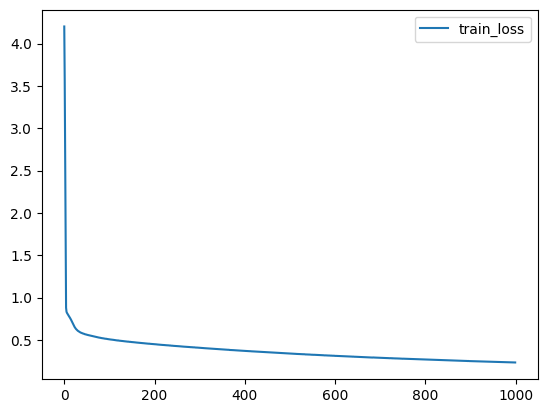

In [19]:
from matplotlib import pyplot as plt
plt.plot(losses, label='train_loss')

plt.legend()
plt.show

In [20]:
# pred_label = []
# true_label = []
# for batch in tqdm(testloader):
#     batch = [i.cuda() for i in batch]
#     sent_id, masks, labels = batch

#     preds = model(sent_id, masks)
#     #pred_label.extend(torch.argmax(preds, axis = 1).cpu())
#     pred_label.extend(preds.cpu())
#     true_label.extend(labels.cpu())

In [21]:
#在上面的代码中，我们首先定义了两个空列表pred_label和true_label来存储
#模型的预测标签和真实标签。然后，我们遍历测试集并对每个批次进行预测
#。将预测值和真实值添加到相应的列表中后，我们可以使用
#sklearn库中的mean_absolute_error函数来计算MAE。
#最后，我们将MAE打印出来。
from sklearn.metrics import mean_absolute_error

# pred_label = []
# true_label = []
pred_label_1 = []
pred_label_2 = []
true_label_1 = []
true_label_2 = []
for batch in tqdm(testloader):
    batch = [i.cuda() for i in batch]
    sent_id, masks, labels = batch

    preds = model(sent_id, masks)
    # pred_label.extend(preds.detach().cpu().numpy())
    # true_label.extend(labels.detach().cpu().numpy())
    pred_label_1.extend(preds[:, 0].detach().cpu().numpy())
    pred_label_2.extend(preds[:, 1].detach().cpu().numpy())
    true_label_1.extend(labels[:, 0].detach().cpu().numpy())
    true_label_2.extend(labels[:, 1].detach().cpu().numpy())

# mae = mean_absolute_error(true_label, pred_label)
mae_1 = mean_absolute_error(true_label_1, pred_label_1)
mae_2 = mean_absolute_error(true_label_2, pred_label_2)

#print(f'MAE: {mae}')

print(f'MAE for Valence: {mae_1}')
print(f'MAE for Arousal: {mae_2}')
#Ckipall2000,MAE for Valence: 0.9184504151344299,MAE for Arousal: 1.0241398811340332


100%|██████████| 81/81 [00:05<00:00, 14.50it/s]

MAE for Valence: 0.8936818838119507
MAE for Arousal: 0.9606467485427856


In [22]:
# def predict_sentiment(sentence, model, tokenizer):
#     encoded_sent = tokenizer.encode_plus(
#         sentence,
#         truncation=True,
#         max_length=50,
#         add_special_tokens=True,
#         # pad_to_max_length=True,
#         padding='longest',
#         return_attention_mask=True,
#         return_tensors='pt'
#     )
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     input_ids = encoded_sent['input_ids'].to(device)
#     attention_mask = encoded_sent['attention_mask'].to(device)

#     with torch.no_grad():
#         output = model(input_ids, attention_mask)

#     return output.item()

def predict_sentiment(sentence, model, tokenizer):
    encoded_sent = tokenizer.encode_plus(
        sentence,
        truncation=True,
        max_length=50,
        add_special_tokens=True,
        padding='longest',
        return_attention_mask=True,
        return_tensors='pt'
    )
    #device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    device = torch.device('cuda'if torch.cuda.is_available() else print("gpu error"))
    input_ids = encoded_sent['input_ids'].to(device)
    attention_mask = encoded_sent['attention_mask'].to(device)

    with torch.no_grad():
        output = model(input_ids, attention_mask)

    return output.cpu().numpy()

In [23]:
sentence = "傻逼嗎?"
score = predict_sentiment(sentence, model, tokenizer)
print(sentence,score-(5,5))
sentence = "你害我輸了"
score = predict_sentiment(sentence, model, tokenizer)
print(sentence,score-(5,5))
sentence = "可惡，你害我放槍了"
score = predict_sentiment(sentence, model, tokenizer)
print(sentence,score-(5,5))
sentence = "就等你這張"
score = predict_sentiment(sentence, model, tokenizer)
print(sentence,score-(5,5))
sentence = "不知道要出哪張"
score = predict_sentiment(sentence, model, tokenizer)
print(sentence,score-(5,5))
sentence = "你到底會不會打牌"
score = predict_sentiment(sentence, model, tokenizer)
print(sentence,score-(5,5))
sentence = "難過"
score = predict_sentiment(sentence, model, tokenizer)
print(sentence,score-(5,5))
sentence = "你很討厭"
score = predict_sentiment(sentence, model, tokenizer)
print(sentence,score-(5,5))
sentence = "你老是盯我的牌，讓我很不舒服。"
score = predict_sentiment(sentence, model, tokenizer)
print(sentence,score-(5,5))
sentence = "我放槍了，這場遊戲讓我很失望。"
score = predict_sentiment(sentence, model, tokenizer)
print(sentence,score-(5,5))
sentence = "很不友善"
score = predict_sentiment(sentence, model, tokenizer)
print(sentence,score-(5,5))
sentence = "太可惡了"
score = predict_sentiment(sentence, model, tokenizer)
print(sentence,score-(5,5))
sentence = "讓我多想想呢"
score = predict_sentiment(sentence, model, tokenizer)
print(sentence,score-(5,5))
sentence = "我很高興"
score = predict_sentiment(sentence, model, tokenizer)
print(sentence,score-(5,5))
sentence = "我高興到不行"
score = predict_sentiment(sentence, model, tokenizer)
print(sentence,score-(5,5))
sentence = "生氣"
score = predict_sentiment(sentence, model, tokenizer)
print(sentence,score-(5,5))



傻逼嗎? [[-2.5941906   0.96016932]]
你害我輸了 [[-0.95566273  2.32951021]]
可惡，你害我放槍了 [[-1.73231626  2.34495354]]
就等你這張 [[ 1.26421547 -0.90716171]]
不知道要出哪張 [[-0.02972937 -0.89277649]]
你到底會不會打牌 [[-0.83278704  0.69432592]]
難過 [[-1.91449165  1.41870689]]
你很討厭 [[-2.82957554  1.86379623]]
你老是盯我的牌，讓我很不舒服。 [[-0.97671461  1.76044226]]
我放槍了，這場遊戲讓我很失望。 [[-1.4649322   2.06424665]]
很不友善 [[-2.13107753 -0.04043198]]
太可惡了 [[-3.20561087  2.34749079]]
讓我多想想呢 [[ 0.72984791 -0.97455931]]
我很高興 [[2.74808073 1.91086531]]
我高興到不行 [[0.0402813  2.47404861]]
生氣 [[-0.19509745 -0.14579964]]


In [24]:
torch.save(model.state_dict(), '../DongModel/CkipAll1000DummySmooth')
model.load_state_dict(torch.load('../DongModel/CkipAll1000DummySmooth'))
model.eval()
sentence = "胡屁胡"
score = predict_sentiment(sentence, model, tokenizer)
print(score)

[[2.9984984 6.149753 ]]
